# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft?) tension constraint.


In [ ]:
#| default exp isogonal

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

from scipy.sparse import csc_matrix

## Definition of the cell shape tensor

Now based off of the sides

(-0.6, 1.6, -0.08660254037844387, 1.818653347947321)

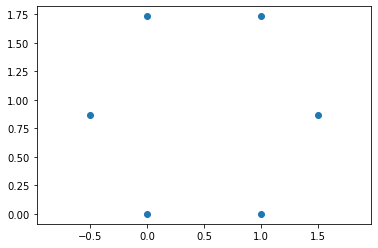

In [ ]:
polygon = np.array([[0, 0],
                    [1, 0],
                    [1+1/2, sqrt(3)/2],
                    [1, sqrt(3)],
                    [0, sqrt(3)],
                    [-1/2, sqrt(3)/2]
                   ])

polygon += np.random.normal(size=(6,2), scale=0)

plt.scatter(*polygon.T)
plt.axis("equal")

In [ ]:
polygon.shape

(6, 2)

In [ ]:
#| export

def get_shape_tensor(poly: NDArray[Shape["N, 2"], Float], metric=False):
    """Shape tensor. normalized so that isotropic shape with unit edge length is identity"""
    edges = poly - anp.roll(poly, 1, axis=0)
    if metric: # don't normalize
        return 2 * anp.mean(anp.einsum("ei,ej->ije", edges, edges), axis=-1)
    lengths = anp.linalg.norm(edges, axis=-1)
    tensor = 2*anp.mean(anp.einsum("ei,ej->ije", edges, edges)/lengths, axis=-1)
    return tensor

In [ ]:
# note: only metric transforms cleanly under shear etc

get_shape_tensor(polygon, metric=False)

array([[1., 0.],
       [0., 1.]])

In [ ]:
# note also: the shape tensor == id does not guarantee that e.g. a hexgon is perfectly symemtric!
# is not injective

get_shape_tensor(polygon.dot(shear_mat(1.2)), metric=False)

array([[1.31143962, 0.        ],
       [0.        , 0.73993   ]])

## New triangle-based shape tensor

In [ ]:
#| export

def get_triangle_shape_tensor(poly: NDArray[Shape["N, 2"], Float],):
    
    center = anp.mean(poly, axis=0)
    triangles = anp.stack([np.stack(poly.shape[0]*[center]), poly, anp.roll(poly, 1, axis=0)], axis=1)
    signed_areas = anp.sum(triangles[...,0]*anp.roll(triangles[...,1], 1, axis=1)
                          - anp.roll(triangles[...,0], 1, axis=1)*triangles[...,1], axis=1)/2
    orientations = signed_areas / anp.abs(signed_areas)
    triangle_edges = triangles - anp.roll(triangles, 1, axis=1)
    
    tensor = anp.mean(anp.einsum("vei, vej->ijv", triangle_edges, triangle_edges)* orientations, axis=-1)
    return 2/3*tensor

(-0.6, 1.6, -0.08660254037844387, 1.818653347947321)

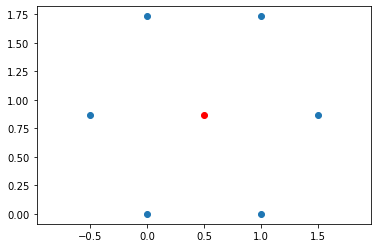

In [ ]:
polygon = np.array([[0, 0],
                    [1, 0],
                    [1+1/2, sqrt(3)/2],
                    [1, sqrt(3)],
                    [0, sqrt(3)],
                    [-1/2, sqrt(3)/2]
                   ])
#polygon += np.random.normal(size=(6,2), scale=0.1)
center = anp.mean(polygon, axis=0)
triangles = anp.stack([np.stack(polygon.shape[0]*[center]), polygon, anp.roll(polygon, 1, axis=0)],
                      axis=1)

plt.scatter(*polygon.T)
plt.scatter(*center, c="r")

#for ix, tri in enumerate(triangles):
#    plt.scatter(*(tri+np.random.normal(size=2, scale=.05)).T, marker="x")

plt.axis("equal")

In [ ]:
get_triangle_shape_tensor(polygon)

array([[1., 0.],
       [0., 1.]])

In [ ]:
tri_edges = triangles - anp.roll(triangles, 1, axis=1)
tri_units = (tri_edges.T / anp.linalg.norm(tri_edges, axis=-1).T).T
signed_areas = anp.sum(triangles[...,0]*anp.roll(triangles[...,1], 1, axis=1)
                       -anp.roll(triangles[...,0], 1, axis=1)*triangles[...,1], axis=1)/2



# test triangle
tri = triangles[0]
edges = tri_edges[0]
units = tri_units[0]



triangles.shape, tri_units.shape, tri_edges.shape

((6, 3, 2), (6, 3, 2), (6, 3, 2))

In [ ]:
anp.mean(anp.einsum("vei, vej->ijv", tri_edges, tri_edges) *  signed_areas, axis=-1)

array([[ 0.64909248, -0.03541244],
       [-0.03541244,  0.69330407]])

In [ ]:
[polygon_area(x) for x in triangles]

[0.40136074616825823,
 0.37223111623739535,
 0.49026596251068905,
 0.4269928189426338,
 0.5016591377826222,
 0.4125834947350558]

array([0.40136075, 0.37223112, 0.49026596, 0.42699282, 0.50165914,
       0.41258349])

In [ ]:
triangles[:,:,1], triangles[...,1]

(array([[ 0.8739188 ,  0.0421292 ,  0.9544366 ],
        [ 0.8739188 , -0.09163961,  0.0421292 ],
        [ 0.8739188 ,  0.83565379, -0.09163961],
        [ 0.8739188 ,  1.68211508,  0.83565379],
        [ 0.8739188 ,  1.82081776,  1.68211508],
        [ 0.8739188 ,  0.9544366 ,  1.82081776]]),
 array([[ 0.8739188 ,  0.0421292 ,  0.9544366 ],
        [ 0.8739188 , -0.09163961,  0.0421292 ],
        [ 0.8739188 ,  0.83565379, -0.09163961],
        [ 0.8739188 ,  1.68211508,  0.83565379],
        [ 0.8739188 ,  1.82081776,  1.68211508],
        [ 0.8739188 ,  0.9544366 ,  1.82081776]]))

In [ ]:
def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(pts[:,0]*anp.roll(pts[:,1], 1, axis=0) - anp.roll(pts[:,0], 1, axis=0)*pts[:,1])/2


## Code for mesh energy

In [ ]:
#| export

@patch
def get_face_neighbors(self: Vertex):
    """Get face neighbors of vertex"""
    neighbors = []
    start_he = self.incident[0]
    he = start_he
    returned = False
    while not returned:
        neighbors.append(he.face)
        he = he.nxt.twin
        returned = (he == start_he)
    return neighbors

@patch
def set_centroid(self: HalfEdgeMesh):
    """Set dual positions to triangle centroid"""
    for fc in self.faces.values():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        fc.dual_coords = np.mean(vecs, axis=0)

@patch
def transform_dual_vertices(self: HalfEdgeMesh, trafo: Union[Callable, NDArray[Shape["2, 2"], Float]]):
    for fc in self.faces.values():
        if isinstance(trafo, Callable):
            fc.dual_coords = trafo(fc.dual_coords)
        else:
            fc.dual_coords = trafo.dot(fc.dual_coords)

In [ ]:
#| export

# new plotting functions

@patch
def cellplot(self: HalfEdgeMesh, alpha=1):
    """Plot based on primal positions. Might be slow because loops over faces"""
    for fc in self.faces.values():
        for he in fc.hes:
            nghb = he.twin.face
            if nghb is not None:
                line = np.stack([fc.dual_coords, nghb.dual_coords])
                plt.plot(*line.T, c="k", alpha=alpha)

@patch
def labelplot(self: HalfEdgeMesh, vertex_labels=True, face_labels=True,
                     halfedge_labels=False, cell_labels=False):
    """for debugging purposes, a fct to plot a trimesh with labels attached"""
    if face_labels:
        for fc in self.faces.values():
            centroid = np.mean([he.vertices[0].coords for he in fc.hes], axis=0)
            plt.text(*centroid, str(fc._fid), color="k")
    if vertex_labels:
        for v in self.vertices.values():
            plt.text(*(v.coords+np.array([0,.05])), str(v._vid),
                     color="tab:blue", ha="center")
    if cell_labels:
        for v in self.vertices.values():
            nghbs = v.get_face_neighbors()
            if not (None in nghbs):
                center = np.mean([fc.dual_coords for fc in nghbs], axis=0)
                plt.text(*(center), str(v._vid),
                         color="tab:blue", ha="center")
    if halfedge_labels:
        for he in self.hes.values():
            if he.duplicate:
                centroid = np.mean([v.coords for v in he.vertices], axis=0)
                plt.text(*centroid, str(he._heid), color="tab:orange")

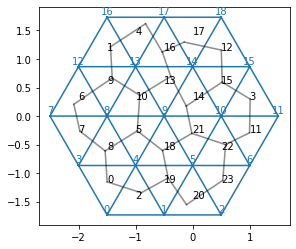

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

#mesh.flip_edge(86)  # this creates an example of an edge with != 6 sides
mesh.set_centroid()
mesh.transform_dual_vertices(lambda x: x+np.random.normal(scale=.075))
mesh.set_rest_lengths() 

mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot()

plt.gca().set_aspect("equal", adjustable="box");

## now check that the shape tensor computation works with the correct shape tensor for each cell, and the right energy

In [ ]:
#| export

@patch
def get_shape_tensors(self: HalfEdgeMesh):
    """Get current shape tensors as dict"""
    # iterate around vertex.
    result_dict = {}
    for v in self.vertices.values():
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            polygon = np.stack([fc.dual_coords for fc in neighbors])
            result_dict[v._vid] = get_shape_tensor(polygon, metric=True)
        else: # leave at default value
            result_dict[v._vid] = np.eye(2)
    return result_dict

@patch
def set_rest_shapes(self: HalfEdgeMesh):
    """Set rest shapes to current shapes"""
    shape_dict = self.get_shape_tensors()
    for v in self.vertices.values():
        v.rest_shape = shape_dict[v._vid]

In [ ]:
#| export

def get_shape_energy(tensor, rest_shape=np.eye(2), mod_shear=0, mod_bulk=1):
    delta = tensor-rest_shape
    return mod_shear*np.trace(delta@delta)+mod_bulk*np.trace(delta)**2

@patch
def get_shape_energies(self: HalfEdgeMesh, mod_shear=0, mod_bulk=1):
    """Does not set energy of boundary vertices"""
    energy_dict = {}
    tensors = mesh.get_shape_tensors()
    for key, val in tensors.items():
        if not (None in self.vertices[key].get_face_neighbors()):
            energy_dict[key] = get_shape_energy(val, rest_shape=mesh.vertices[key].rest_shape,
                                                mod_shear=mod_shear, mod_bulk=mod_bulk)
    return energy_dict

In [ ]:
get_shape_energy(np.diag([1.1, .9]), np.eye(2), mod_bulk=1, mod_shear=0)

1.232595164407831e-32

In [ ]:
get_shape_energy(np.diag([1.1, .9]), np.eye(2), mod_bulk=0, mod_shear=1)

0.02000000000000001

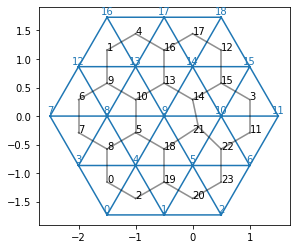

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)
mesh.set_rest_lengths() 

for v in mesh.vertices.values():
    v.rest_shape = np.eye(2)/3 # rescale the rest shapes

mesh.set_centroid()
#mesh.transform_dual_vertices(lambda x: shear_mat(1)@x)

mesh.faces[21].dual_coords += np.array([.1, .1])

mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot()
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
shape_tensors = {key: val for key, val in mesh.get_shape_tensors().items()}


shape_tensors[10], shape_tensors[9],  shape_tensors[5],  shape_tensors[13]
# looks good

(array([[ 0.30666667, -0.0196225 ],
        [-0.0196225 ,  0.32075499]]),
 array([[0.37333333, 0.01371083],
        [0.01371083, 0.32075499]]),
 array([[0.34      , 0.02591168],
        [0.02591168, 0.37849002]]),
 array([[0.33333333, 0.        ],
        [0.        , 0.33333333]]))

array([[ 0.30666667, -0.0196225 ],
       [-0.0196225 ,  0.32075499]])

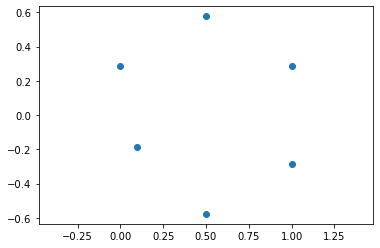

In [ ]:
# double check the vertices are identified correctly
pts = np.stack([fc.dual_coords for fc in mesh.vertices[10].get_face_neighbors()])
plt.scatter(*pts.T)
plt.axis("equal")

get_shape_tensor(pts, metric=True)

In [ ]:
np.trace(shape_tensors[10]-mesh.vertices[10].rest_shape)**2

0.0015401707292898646

In [ ]:
get_shape_energy(shape_tensors[10], mesh.vertices[10].rest_shape)

0.0015401707292898646

In [ ]:
mesh.get_shape_energies()

{4: 0.0,
 5: 0.0026856597378185926,
 8: 0.0,
 9: 0.0007519473106693164,
 10: 0.0015401707292898646,
 13: 0.0,
 14: 3.0814879110195774e-33}

In [ ]:
0.0026856597378185926 + 0.0007519473106693164 + 0.0015401707292898646

0.004977777777777774

this looks correct to me

now let's check the energy function - does it get the correct result. Yes.,

Also did a detailed check of the different components, e.g. the face list indices etc

In [ ]:
get_E , _ = mesh.get_primal_energy_fct(mod_bulk=1, mod_shear=0, angle_penalty=0)
x0 = mesh.dual_vertices_to_initial_cond()

In [ ]:
get_E(x0), np.mean(list(mesh.get_shape_energies().values()))
# differences might arise from the translation term which I have commented out

(0.0007111111111111105, 0.0007111111111111105)

In [ ]:
shape_tensors[14]

# shape tensors are also consistently computed in energy function
#4 ok, 5 ok, 8 ok, 9 ok, 10 ok, 13 ok, 14 ok

array([[0.33333333, 0.        ],
       [0.        , 0.33333333]])

In [ ]:
x0.shape

(48,)

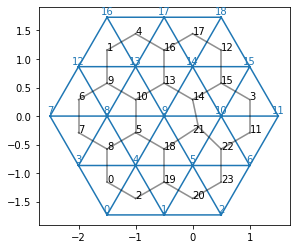

In [ ]:
mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot()
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
primal_face_list = [np.array([ 0,  8,  5, 18, 19,  2]), # check - 4
                    np.array([18, 21, 22, 23, 20, 19]), # check - 5
                    np.array([ 5,  8,  7,  6,  9, 10]), # check - 8
                    np.array([ 5, 10, 13, 14, 21, 18]), # check - 9
                    np.array([11, 22, 21, 14, 15,  3]), # check - 10
                    np.array([ 1,  4, 16, 13, 10,  9]), # check - 13
                    np.array([15, 14, 13, 16, 17, 12])] # check - 14

## Code for primal energy minimization

Need to ``serialize'' half edge mesh for rapid optimization

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


In [ ]:
mesh.dual_vertices_to_initial_cond().shape, len(mesh.faces)

((48,), 24)

In [ ]:
len(mesh.vertices), len([v._vid for v in mesh.vertices.values()
                         if not any([he.face is None for he in v.incident])])

(19, 7)

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
x0.shape

(48,)

## Self intersection problem

(-1.105, 1.205, -1.1, 1.1)

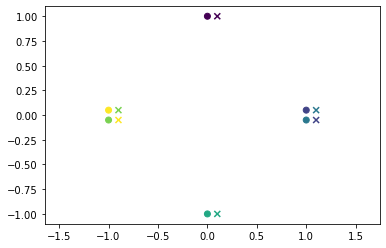

In [ ]:
poly_example = np.array([[0,  1.0],
                         [1,  0.05],
                         [1, -0.05],
                         [0, -1.0],
                         [-1,-0.05],
                         [-1, 0.05]])

poly_intersect = np.array([[0,  1.0],
                           [1, -0.05],
                           [1,  0.05],
                           [0, -1.0],
                           [-1, 0.05],
                           [-1,-0.05]])


plt.scatter(*poly_example.T, c =np.arange(6))
plt.scatter(*(poly_intersect+np.array([.1,0])).T, c =np.arange(6), marker='x')

plt.axis("equal")

In [ ]:
get_triangle_shape_tensor(poly_example)

array([[-1.33333333,  0.        ],
       [ 0.        , -0.85      ]])

In [ ]:
get_triangle_shape_tensor(poly_intersect)

array([[-0.44444444,  0.        ],
       [ 0.        , -0.93222222]])

In [ ]:
metric = False
delta_1 = 10*(get_shape_tensor(poly_example, metric=metric)-np.eye(2))
delta_2 = 10*(get_shape_tensor(poly_intersect, metric=metric)-np.eye(2))

In [ ]:
np.trace(delta_1)**2, np.trace(delta_2)**2

(0.8883333335503402, 1.232595164407831e-30)

In [ ]:
np.trace(delta_1@delta_1), np.trace(delta_2@delta_2)

(0.48220847756072704, 1.2947549213898784)

## Angle constraint energy

In [ ]:
#| export

#try to replace shape tensor based energy by simple area
# to do 1: get area of polygon (using triangle decomposition)
# to do 2: handle case of self-intersection (bow-tie) correcrly - bow tie should decrease area!

def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(pts[:,0]*anp.roll(pts[:,1], 1, axis=0) - anp.roll(pts[:,0], 1, axis=0)*pts[:,1])/2

def polygon_perimeter(pts):
    """perimeter of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(anp.linalg.norm(pts-anp.roll(pts, 1, axis=0), axis=1))


In [ ]:
polygon_perimeter(np.array([[0,0],[0,1],[1,0]])), 2+sqrt(2)

(3.414213562373095, 3.414213562373095)

In [ ]:
polygon_area(np.array([[0,0],[0,1],[1,0]]))

0.5

In [ ]:
# check area & perimeter for self intersect example - looks good!

print([np.round(polygon_area(x), decimals=3) for x in [poly_example, poly_intersect]])
print([np.round(polygon_perimeter(x), decimals=3) for x in [poly_example, poly_intersect]])


[2.1, 1.9]
[5.717, 6.0]


In [ ]:
#| export

@patch
def get_angle_deviation(self: HalfEdgeMesh):
    """Angle between primal and dual edges. For diagnostics"""
    angle_deviation = {}

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None):
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            primal_edge = he.face.dual_coords - he.twin.face.dual_coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = primal_edge / np.linalg.norm(primal_edge)        
            angle_deviation[he._heid] = np.dot(dual_edge, primal_edge)**2
    return angle_deviation

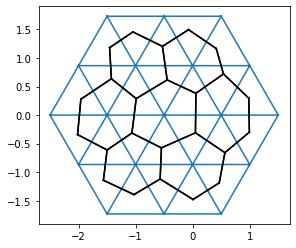

In [ ]:
# iterate over edges and ensure angle primal | dual = 0

mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.set_rest_shapes()  # required, to make the scale of the rest shapes correct.
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05))

mesh.cellplot()
mesh.triplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
sum(mesh.get_angle_deviation().values()) / 2

0.35727140118724726

In [ ]:
## now make this into arrays ... 

e_dual = [] # dual vertices do not move during optiomization, so collect the actual edges
e_lst_primal = [] # for primal, collect the indices

face_key_dict = {key: ix for ix, key in enumerate(sorted(mesh.faces.keys()))}

for he in mesh.hes.values():
    if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
        dual_edge = he.vertices[1].coords-he.vertices[0].coords
        dual_edge = dual_edge / np.linalg.norm(dual_edge)
        primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
        e_dual.append(dual_edge)
        e_lst_primal.append(primal_edge)

e_dual = anp.array(e_dual)
e_lst_primal = anp.array(e_lst_primal)
n_faces = len(mesh.faces)

In [ ]:
# now collect the primal coords

x0 = mesh.dual_vertices_to_initial_cond()

x, y = (x0[:n_faces], x0[n_faces:])
pts = anp.stack([x, y], axis=-1)
e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T

anp.sum(anp.einsum('ei,ei->e', e_primal, e_dual)**2)

0.35727140118724704

In [ ]:
#| export

@patch
def get_primal_energy_fct(self: HalfEdgeMesh, A0=1, P0=6, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2):
    """Get function to compute primal energy from primal vertices."""
    
    # stuff for the shape tensor energy
    primal_face_list = []
    rest_shapes = []
    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            primal_face_list.append(anp.array([fc._fid for fc in neighbors]))
            rest_shapes.append(v.rest_shape)
    # cells might have differing #vertices, so don't make primal face list into array
    rest_shapes = anp.array(rest_shapes)
    n_faces = len(self.faces)

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optiomization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)    
    center = anp.mean([fc.dual_coords for fc in self.faces.values()], axis=0)

    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        # shape energy
        #tensors = []
        E_shape = 0
        for fc in primal_face_list:
            pts = anp.stack([x[fc], y[fc]], axis=-1)
            E_shape = E_shape+mod_bulk*(polygon_area(pts)-A0)**2+mod_shear*(polygon_perimeter(pts)-P0)**2
            #tensors.append(get_shape_tensor(pts, metric=True))
        #tensors = anp.array(tensors)
        #delta = tensors - rest_shapes
        #E_shape = anp.mean(mod_bulk*(delta[:,0,0]+delta[:,1,1])**2
        #                 + mod_shear*(delta[:,0,0]**2+2*delta[:,0,1]**2+delta[:,1,1]**2))
        # angle penalty
        pts = anp.stack([x, y], axis=-1)
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return E_shape + E_angle #+ E_trans
    
    return get_E, agrad(get_E)

## Minimization, constrained  - let's try to find a minimal example of bad behavior

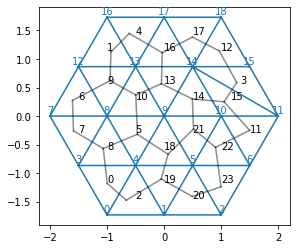

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)
for v in mesh.vertices.values():
    v.rest_shape = np.eye(2)/3 # rescale the rest shapes

mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-mean)

mesh.flip_edge(11)  # this creates an example of an edge with != 6 sides. e.g. 9
mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.06)) #shear_mat(1.2)@x)
#mesh.transform_vertices(shear_mat(1.3)) # 1.31almost 90 degree angles

mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
polygon_area(np.stack([fc.dual_coords for fc in mesh.vertices[4].get_face_neighbors()])), sqrt(3)/2

(0.8690042756511728, 0.8660254037844386)

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct(A0=sqrt(3)/2, P0=2*sqrt(3),mod_bulk=1, mod_shear=.01, angle_penalty=10)
get_E(x0)

0.6588913546195813

In [ ]:
sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", options={"gtol": 1e-3})
print(sol["message"])
get_E(sol["x"])

Optimization terminated successfully.


0.0009345711445238487

In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]

In [ ]:
mesh.get_shape_tensors()[8], mesh.vertices[8].rest_shape, mesh.vertices[8].coords

(array([[0.35071599, 0.05465487],
        [0.05465487, 0.32986961]]),
 array([[0.33333333, 0.        ],
        [0.        , 0.33333333]]),
 array([-1.00000000e+00, -1.63611814e-16]))

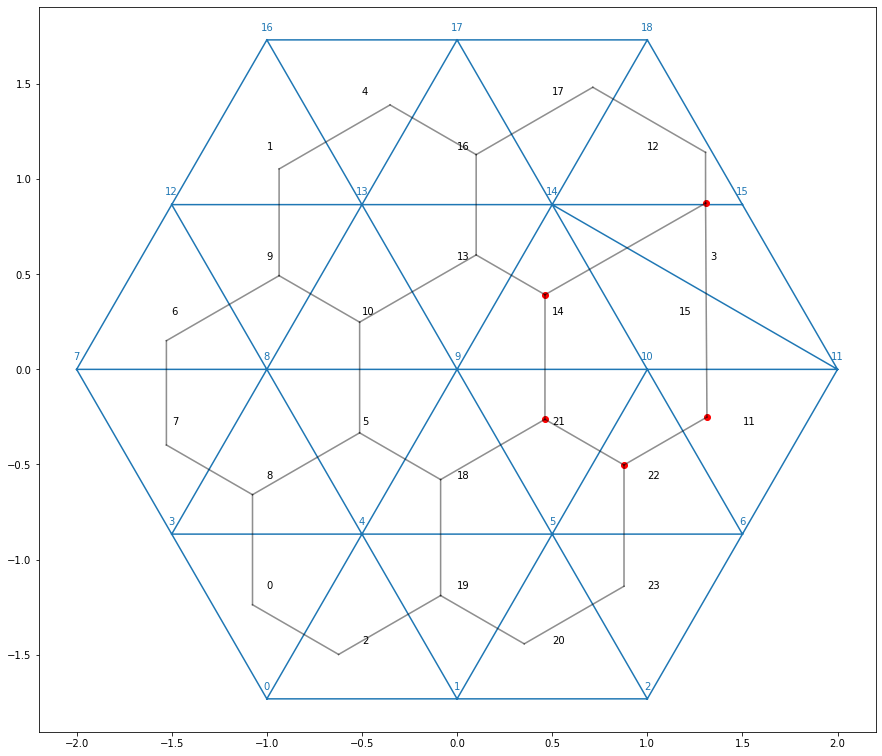

In [ ]:
# completely correct - but can have problem at boundary if there was an edge flip!
# in this case, ever self-intersection can occur.

# actuall;y it already does here!

fig = plt.figure(figsize=(15, 15))

mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot() # halfedge_labels=True


pts = np.stack([fc.dual_coords for fc in mesh.vertices[10].get_face_neighbors()])
plt.scatter(*pts.T, c="r")

#plt.xlim([.5, 2.1])
#plt.ylim([0, 1])

plt.gca().set_aspect("equal", adjustable="box");


In [ ]:
v = 14
pts = np.stack([fc.dual_coords for fc in mesh.vertices[v].get_face_neighbors()])

polygon_area(pts), sqrt(3)/2

(0.8641310965025761, 0.8660254037844386)

In [ ]:
pts

array([[1.30623853, 0.87361281],
       [0.46226473, 0.39243018],
       [0.10037414, 0.60164319],
       [0.10044182, 1.12889082],
       [0.71360931, 1.48294797],
       [1.30619173, 1.14082012],
       [1.30627682, 0.87367911]])

(0.04007900775898632,
 1.3665719502508824,
 0.33790429546684225,
 1.5374738591122987)

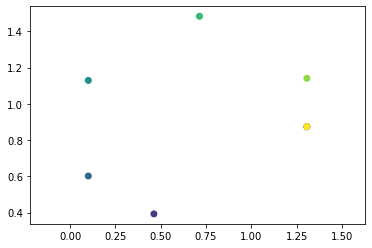

In [ ]:
plt.scatter(*pts.T, c=np.arange(pts.shape[0]))
plt.axis("equal")

In [ ]:
g = get_shape_tensor(pts, metric=True)
delta = g-np.eye(2)/3

delta

array([[ 0.21600975, -0.11175553],
       [-0.11175553,  0.16988761]])

In [ ]:
np.trace(delta)**2

6.923988639753829e-08

In [ ]:
# shape tensor does not capture well that this polygon was massively compressed!

# actua

In [ ]:
get_shape_energy(g, mesh.vertices[10].rest_shape, mod_bulk=1, mod_shear=1)

0.02239378830521303

In [ ]:
mesh.get_shape_tensors()[10]

array([[0.23116446, 0.04614395],
       [0.04614395, 0.41961394]])

In [ ]:
mesh.get_shape_energies(mod_shear=1, mod_bulk=1)

{4: 0.0017239394849860401,
 5: 0.0018772481222517833,
 8: 0.00013016764987692649,
 9: 0.005534605425636237,
 10: 0.02239378830521303,
 13: 0.0007542022217762555,
 14: 0.0016512629342379493}

In [ ]:
# to do: check for errors by writing a function that checks polygon intersection:
# is any point in any other polygon?
# use half-space check to do this

## Full simulation, as example

In [ ]:
# optimizer timin:

# for the 5*5 example:
# .5s for BFGS
# 2s for CG
# 2.5 for BFGS without jac
# 2.6s for Newton-CG
# 1.8 for trust-ncg
# 2 for trust-krylov

# fine to set the gtol to 1e-3

Now we still need to compute the primal edge lengths! indexed by `_heid`

In [ ]:
#| export

@patch
def get_primal_edge_lens(self: HalfEdgeMesh):
    return {he._heid: np.linalg.norm(he.face.dual_coords-he.twin.face.dual_coords)
            for key, he in self.hes.items() if (he.face is not None) and (he.twin.face is not None)}
    
    return None

In [ ]:
#| export

def rotate_about_center(x, angle=pi/2):
    """Rotate pts about center. x.shape = (n_pts, 2)"""
    center = np.mean(x, axis=0)
    return (x-center)@rot_mat(angle)+np.mean(x, axis=0)

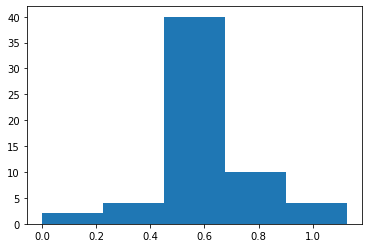

In [ ]:
plt.hist(mesh.get_primal_edge_lens().values(), bins=5);

In [ ]:
primal_lengths = mesh.get_primal_edge_lens()
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(11, 0.00030779883909630413)

In [ ]:
def temp_plot(msh):
    msh.cellplot()
    msh.triplot()
    #plt.title("initial")
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.gca().set_aspect("equal", adjustable="box");


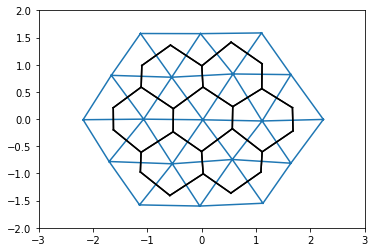

In [ ]:
mesh = get_tri_hemesh(noise=0, nx=5, ny=5)
mesh.set_voronoi(); mesh.set_rest_shapes()  # to make the scale of the rest shapes correct.
mesh.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=.025))
# set origin
mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-mean)

mesh.set_rest_lengths() 
mesh.set_voronoi()

temp_plot(mesh)

In [ ]:
# test the idea of flipping intercalation

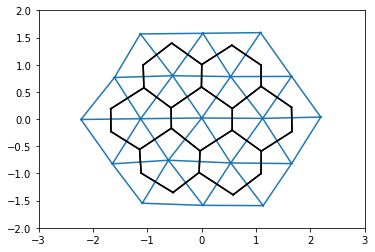

In [ ]:
mesh = get_tri_hemesh(noise=0, nx=5, ny=5)
mesh.set_voronoi(); mesh.set_rest_shapes()  # to make the scale of the rest shapes correct.
mesh.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=.025))
# set origin
mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-mean)

mesh.set_rest_lengths() 
mesh.set_voronoi()

temp_plot(mesh)

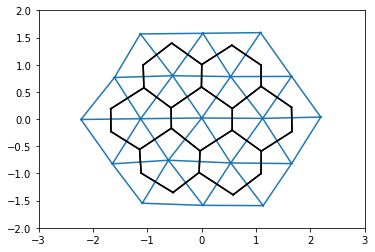

0
1
2
3
4
5
6
7
8
9
10


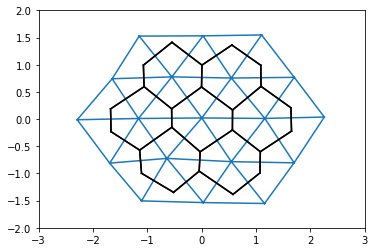

11
12
13
14
15
16
17
18
19
20


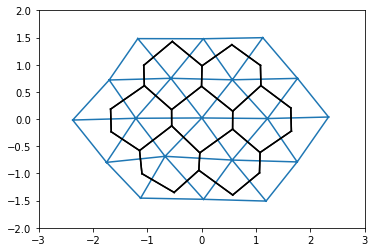

21
22
23
24
25
26
27
28
29
30


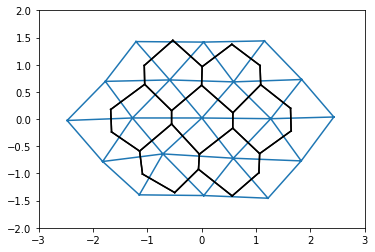

31
32
33
34
35
36
37
38
39
40


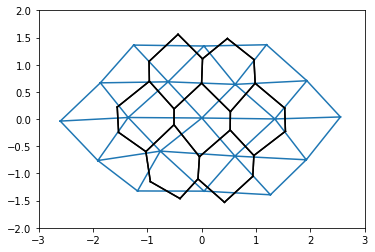

41
42
43
44
45
46
47
48
49
50


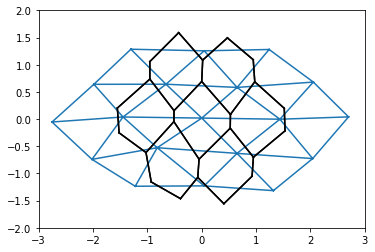

51
52
53
54
55
56
57
58
59
60


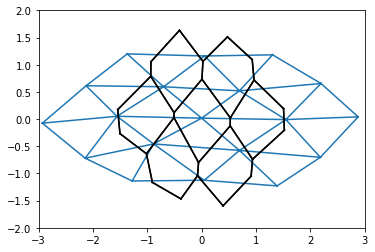

flip


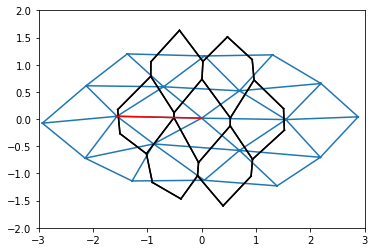

[[-0.51  0.03]
 [-0.51  0.12]]
[[-0.46  0.07]
 [-0.55  0.07]]
61
flip


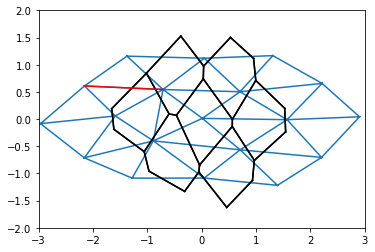

[[-1.02  0.84]
 [-1.02  0.84]]
[[-1.02  0.84]
 [-1.01  0.84]]
62
flip


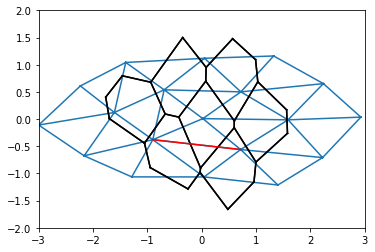

[[-0.02 -0.9 ]
 [-0.03 -0.98]]
[[-0.07 -0.93]
 [ 0.02 -0.94]]
63
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


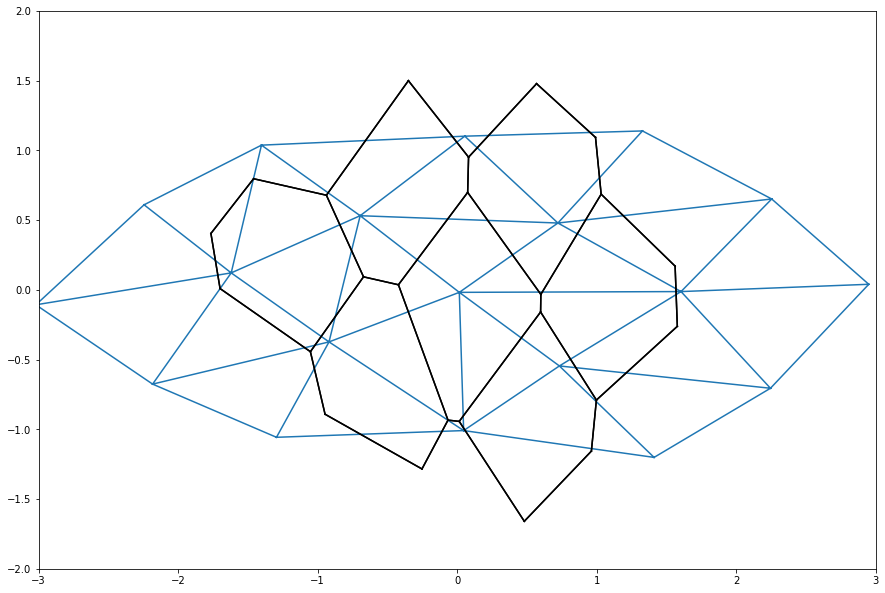

flip


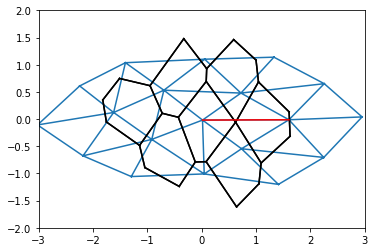

[[ 0.62 -0.06]
 [ 0.62 -0.06]]
[[ 0.62 -0.06]
 [ 0.62 -0.06]]
64
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


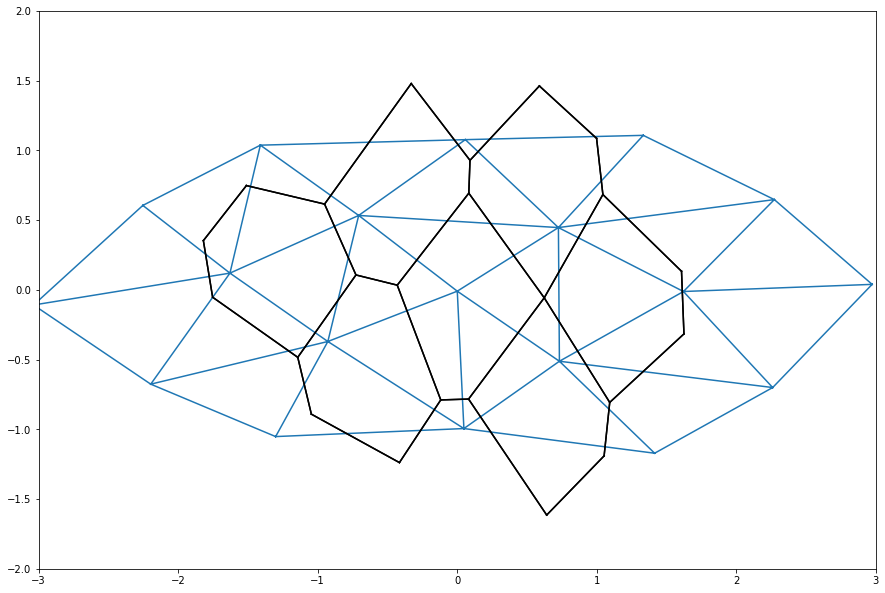

flip


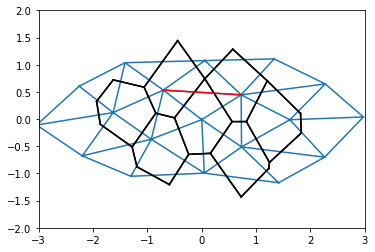

[[0.06 0.74]
 [0.06 0.74]]
[[0.06 0.74]
 [0.06 0.74]]
65
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


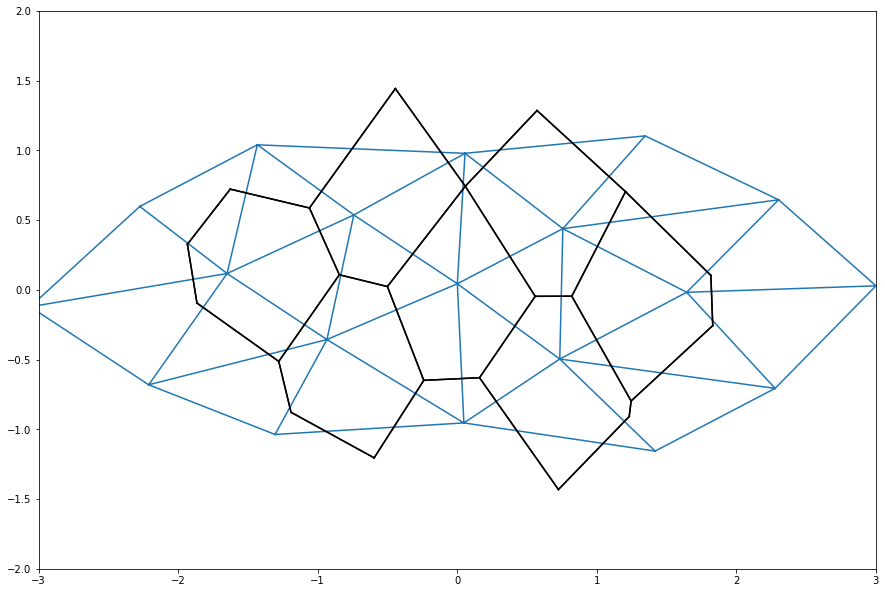

flip


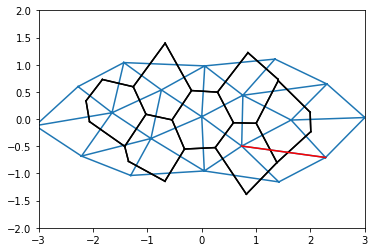

[[ 1.39 -0.8 ]
 [ 1.39 -0.8 ]]
[[ 1.39 -0.8 ]
 [ 1.39 -0.8 ]]
66
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


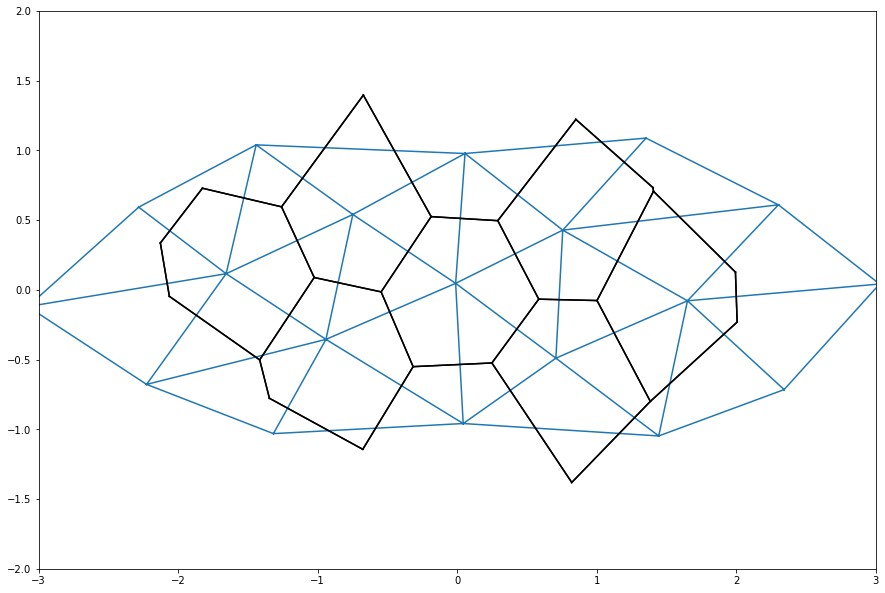

flip


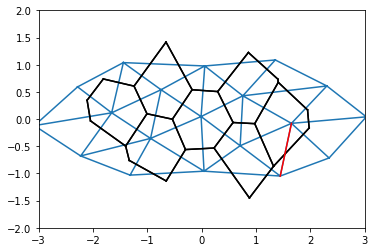

[[ 1.32 -0.87]
 [ 1.32 -0.87]]
[[ 1.32 -0.87]
 [ 1.32 -0.87]]
67
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


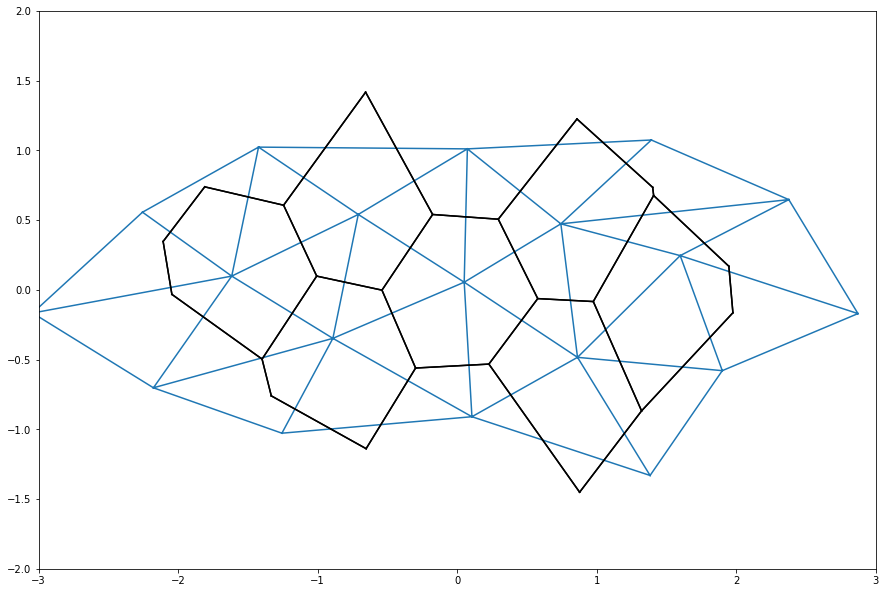

flip


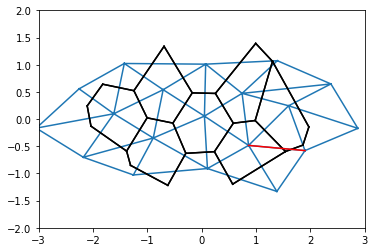

[[ 1.54 -0.6 ]
 [ 1.54 -0.6 ]]
[[ 1.54 -0.6 ]
 [ 1.54 -0.6 ]]
68
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


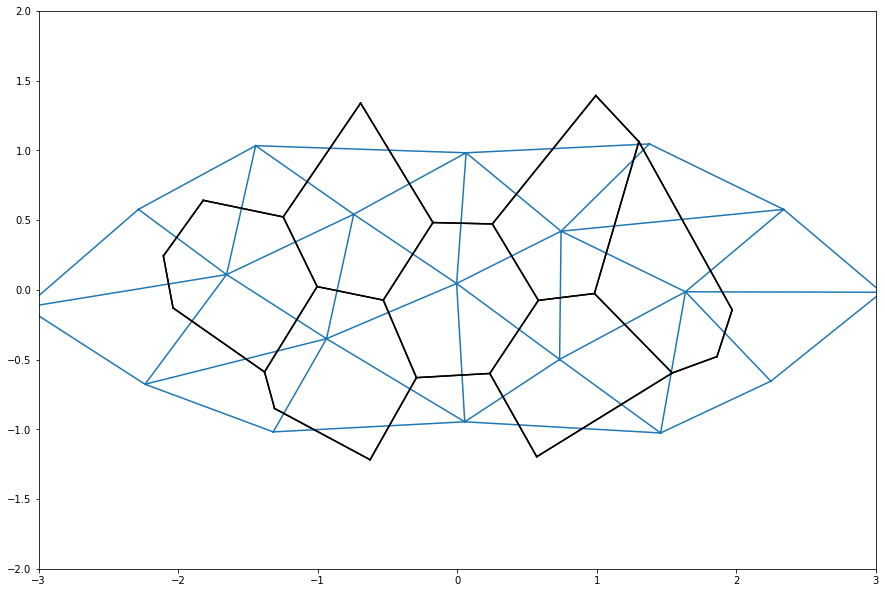

flip


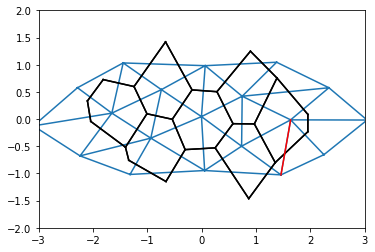

[[ 1.35 -0.8 ]
 [ 1.35 -0.8 ]]
[[ 1.35 -0.8 ]
 [ 1.35 -0.8 ]]
69
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


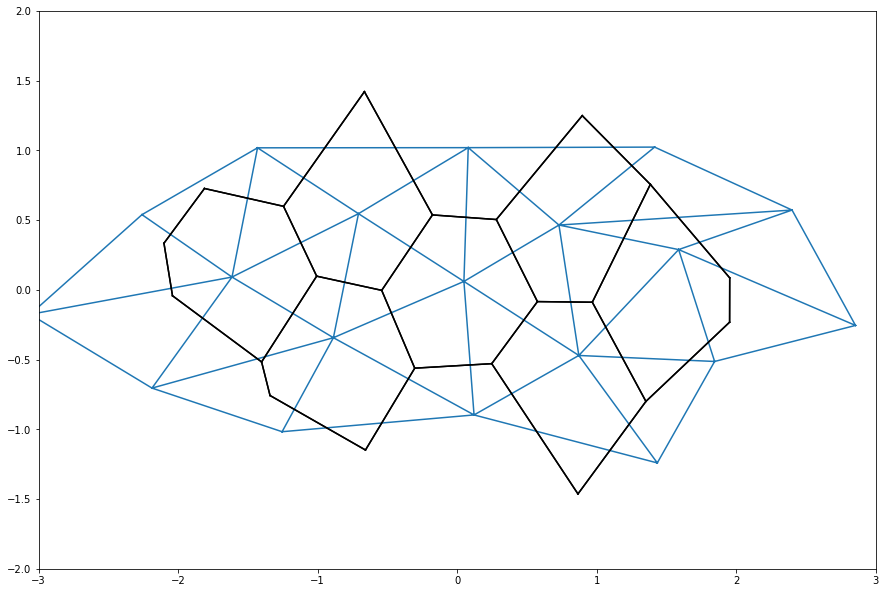

flip


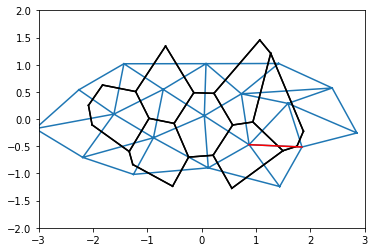

[[ 1.49 -0.58]
 [ 1.49 -0.58]]
[[ 1.49 -0.58]
 [ 1.49 -0.58]]
70
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


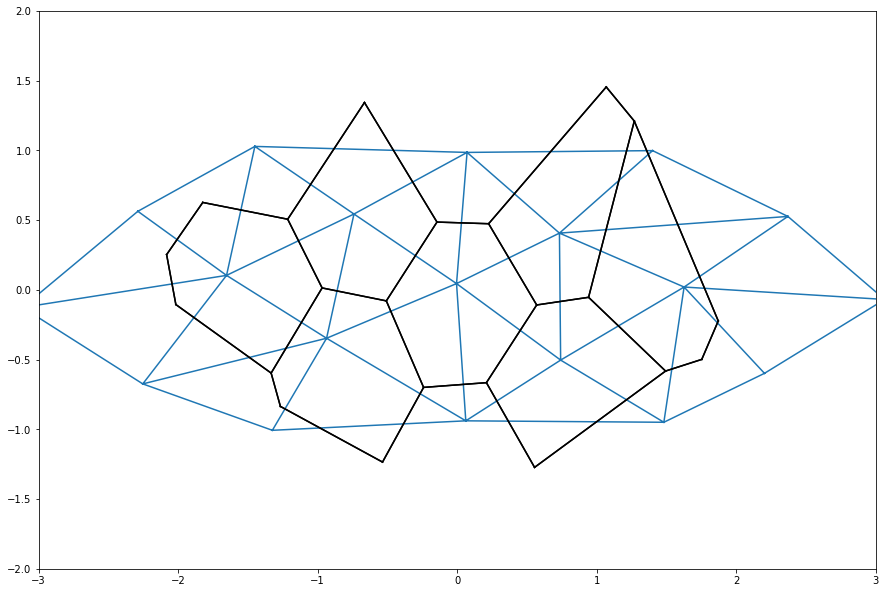

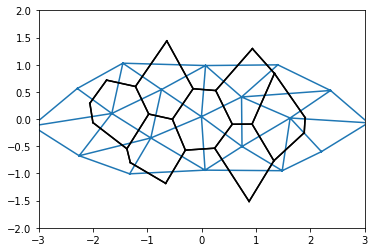

flip


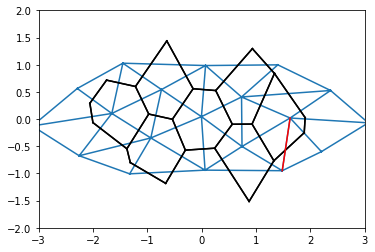

[[ 1.33 -0.77]
 [ 1.33 -0.77]]
[[ 1.33 -0.77]
 [ 1.33 -0.77]]
71
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


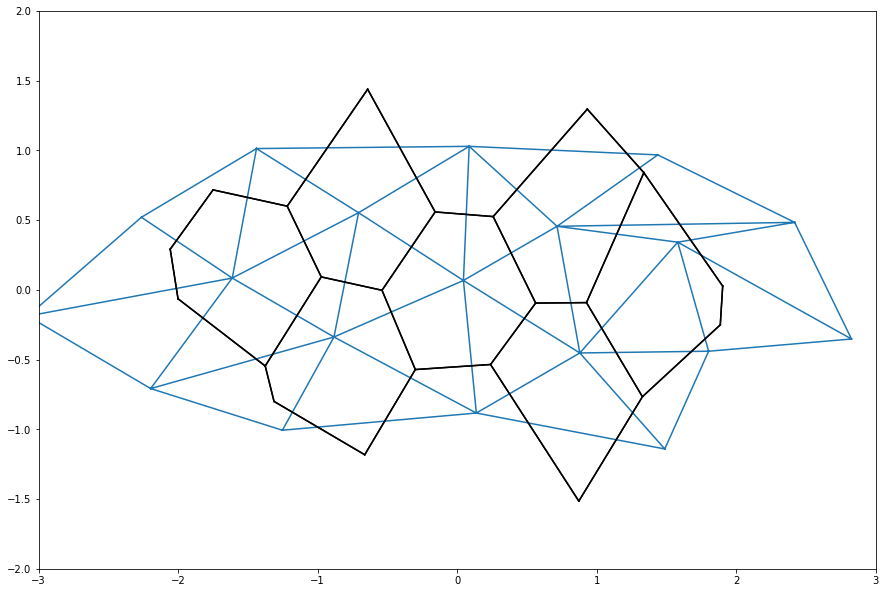

flip


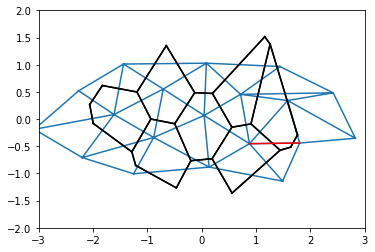

[[ 1.44 -0.57]
 [ 1.44 -0.57]]
[[ 1.44 -0.57]
 [ 1.44 -0.57]]
72
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


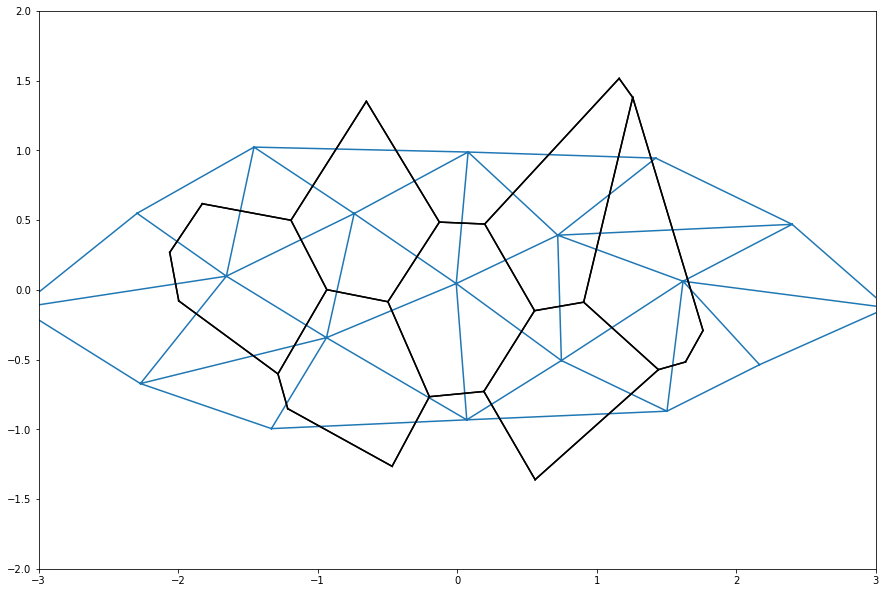

flip


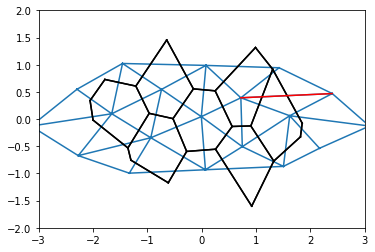

[[1.31 0.92]
 [1.31 0.92]]
[[1.31 0.92]
 [1.31 0.92]]
73
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


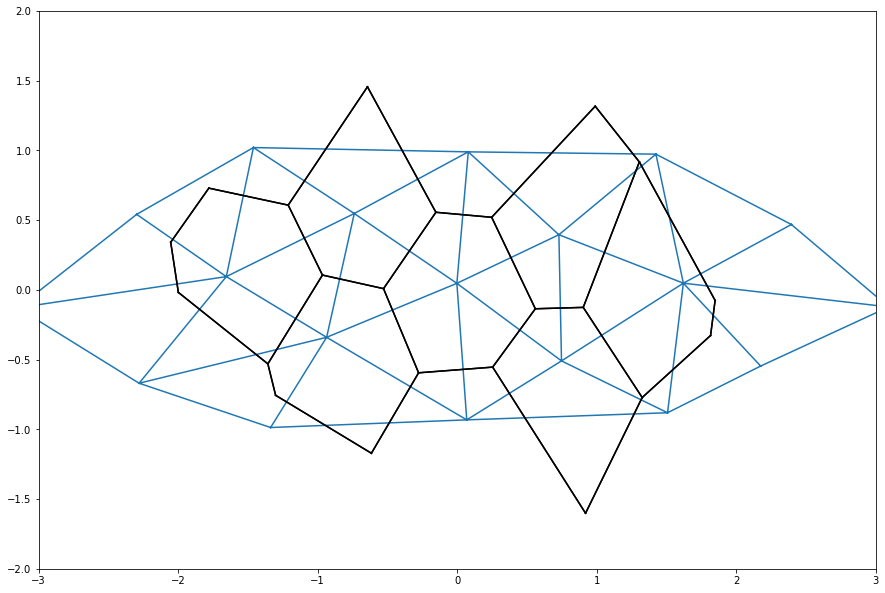

flip


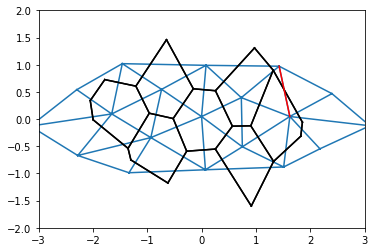

[[1.32 0.9 ]
 [1.32 0.9 ]]
[[1.32 0.9 ]
 [1.32 0.9 ]]
74
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


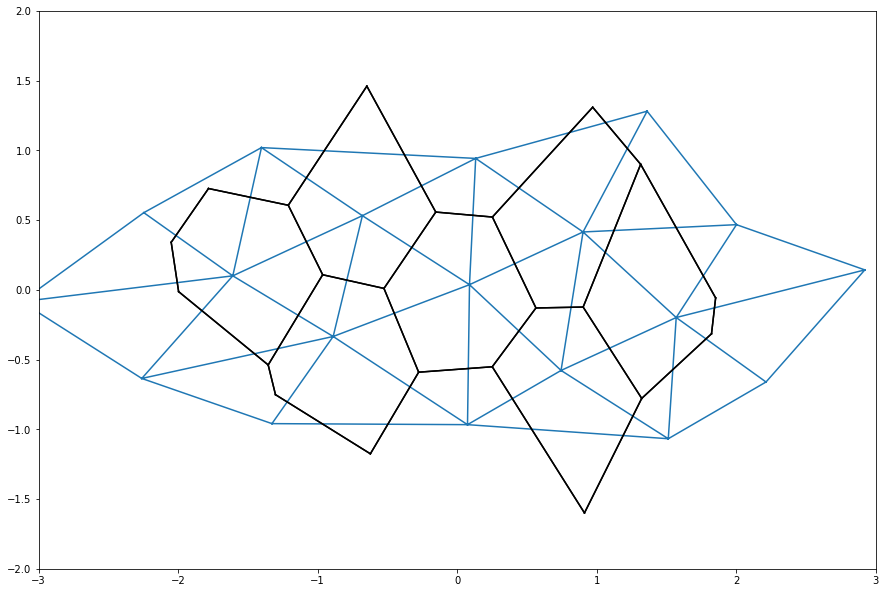

flip


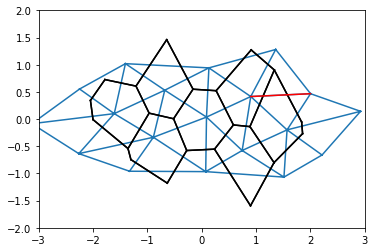

[[1.34 0.9 ]
 [1.34 0.9 ]]
[[1.34 0.9 ]
 [1.34 0.9 ]]
75
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


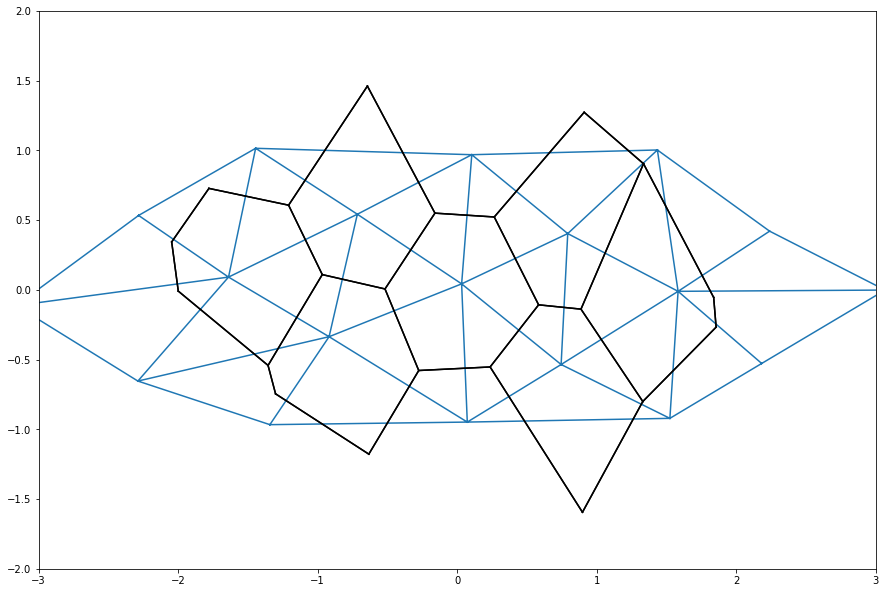

flip


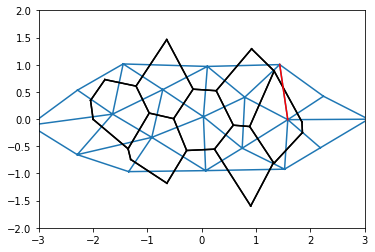

[[1.33 0.88]
 [1.33 0.88]]
[[1.33 0.88]
 [1.33 0.88]]
76
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


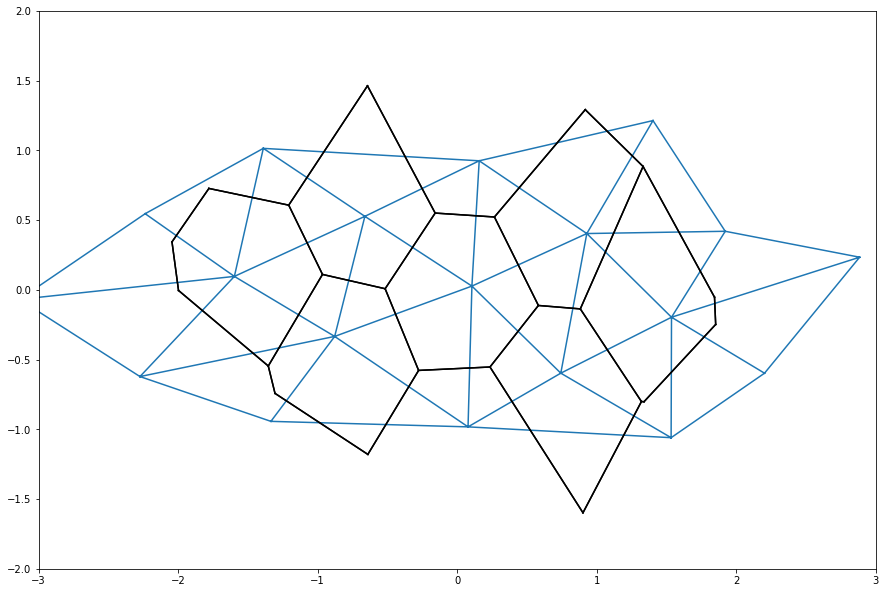

flip


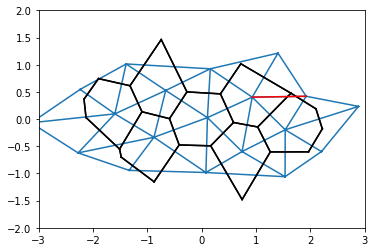

[[1.64 0.48]
 [1.64 0.48]]
[[1.64 0.48]
 [1.64 0.48]]
77
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


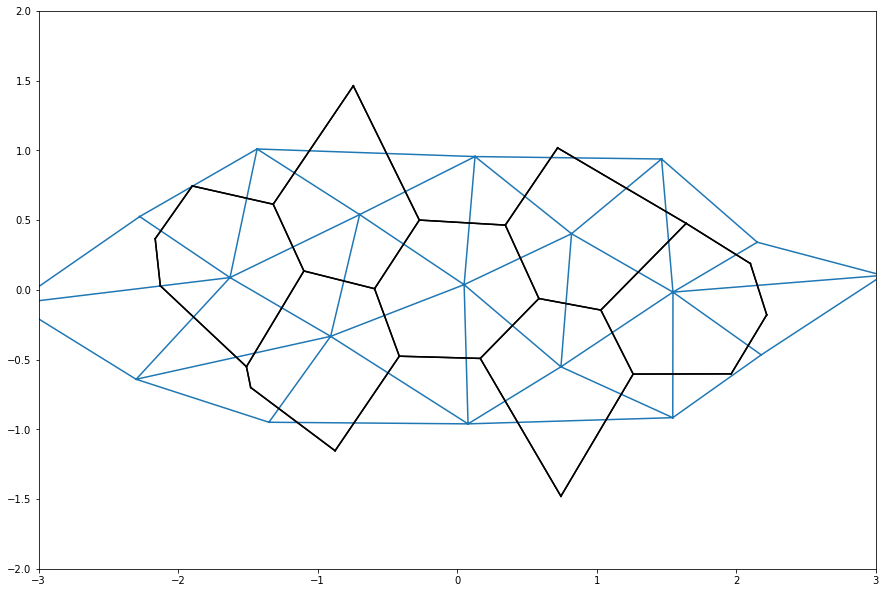

flip


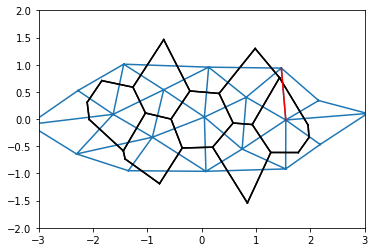

[[1.43 0.76]
 [1.43 0.76]]
[[1.43 0.76]
 [1.43 0.76]]
78
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


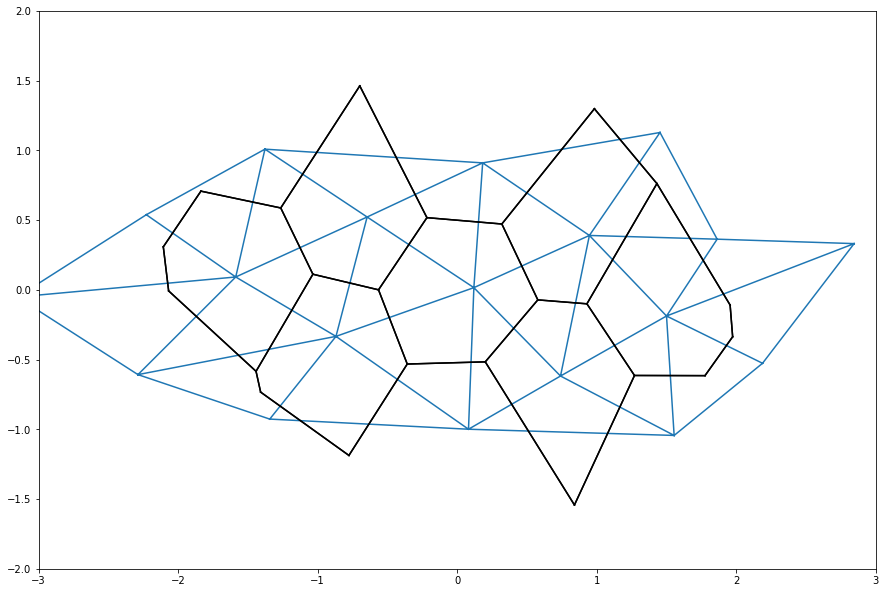

flip


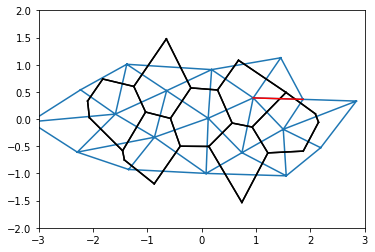

[[1.55 0.49]
 [1.55 0.49]]
[[1.55 0.49]
 [1.55 0.49]]
79
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


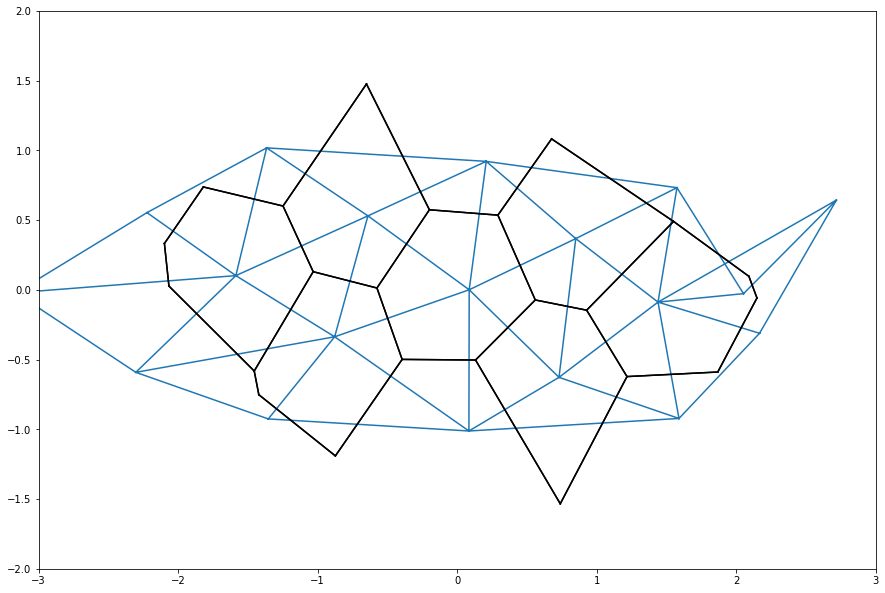

flip


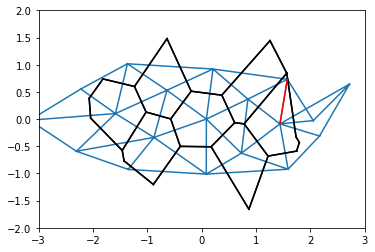

[[1.57 0.84]
 [1.57 0.84]]
[[1.57 0.84]
 [1.57 0.84]]
80
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


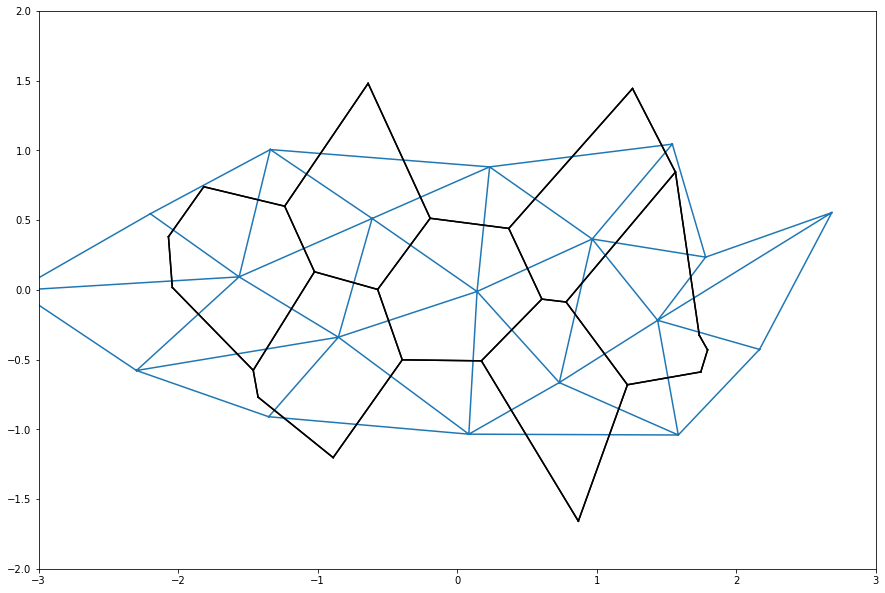

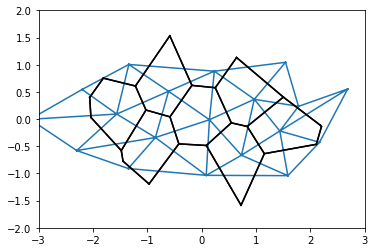

flip


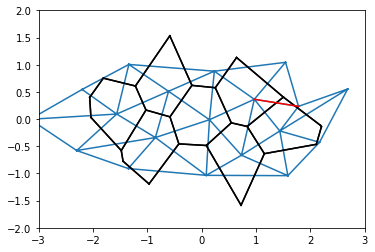

[[1.5 0.4]
 [1.5 0.4]]
[[1.5 0.4]
 [1.5 0.4]]
81
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


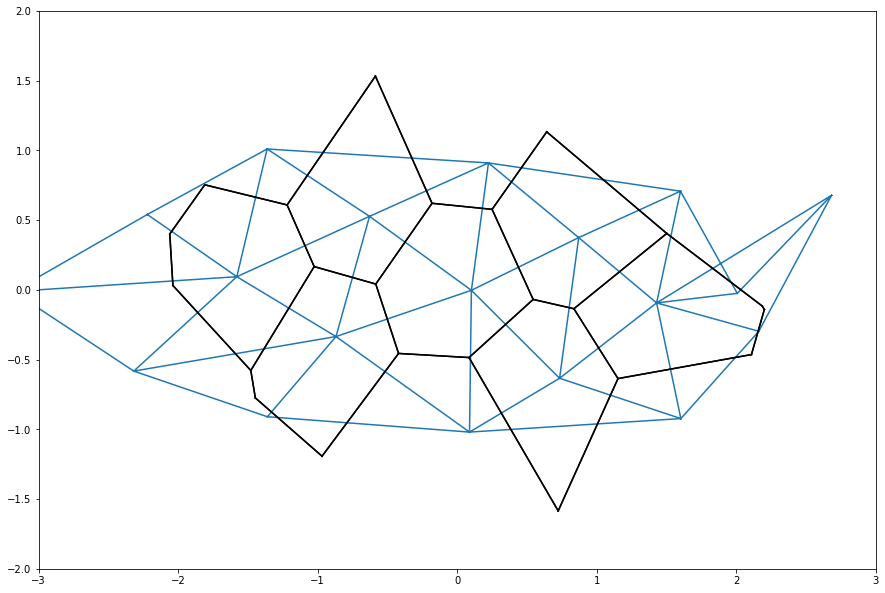

flip


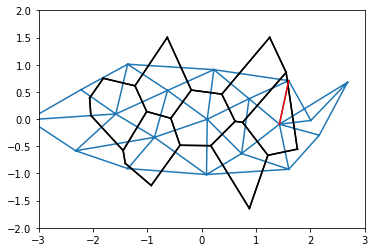

[[1.55 0.86]
 [1.55 0.86]]
[[1.55 0.86]
 [1.55 0.86]]
82
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


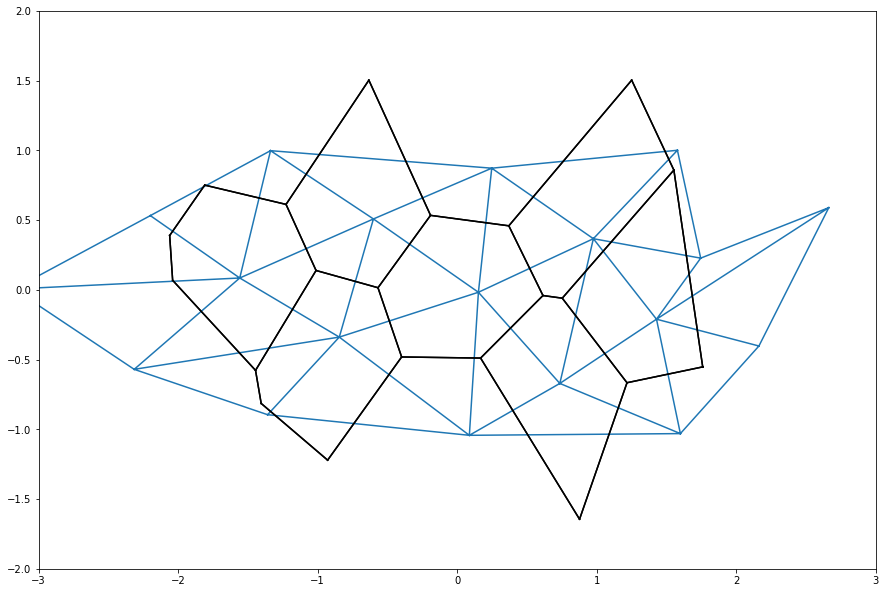

flip


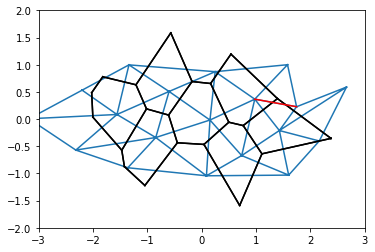

[[1.39 0.38]
 [1.39 0.38]]
[[1.39 0.38]
 [1.39 0.38]]
83
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


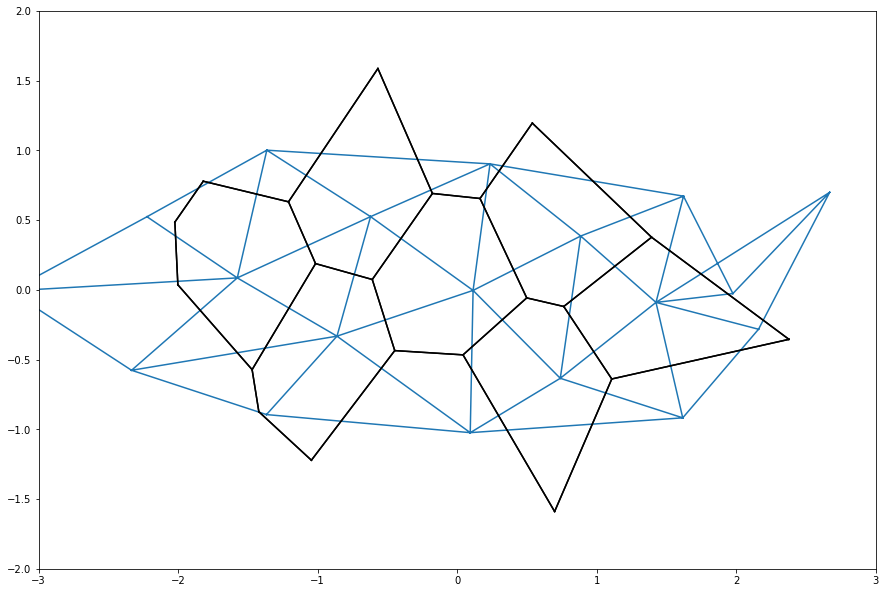

flip


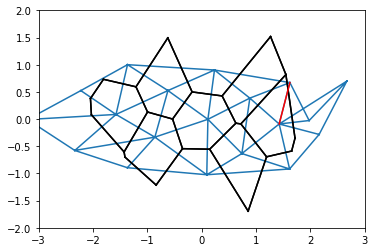

[[1.55 0.82]
 [1.55 0.82]]
[[1.55 0.82]
 [1.55 0.82]]
84
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


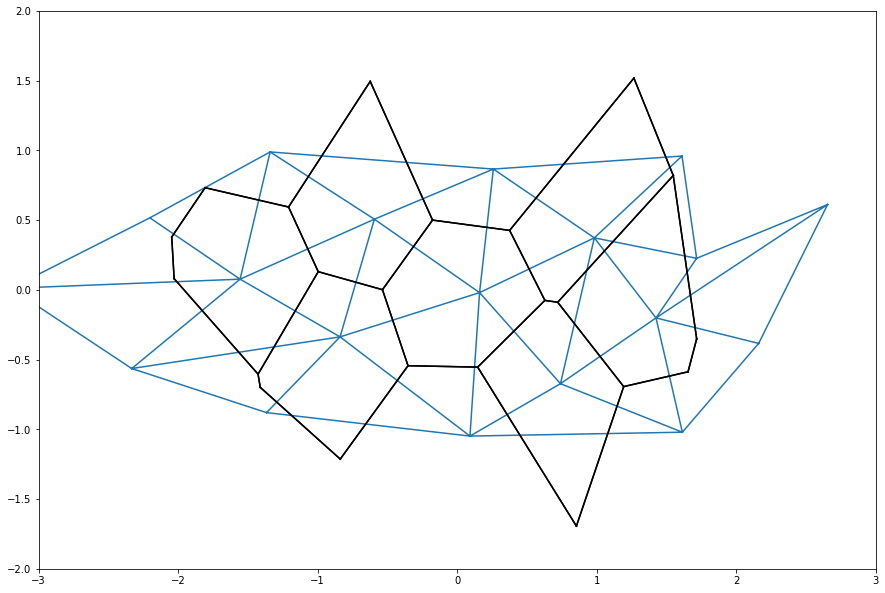

flip


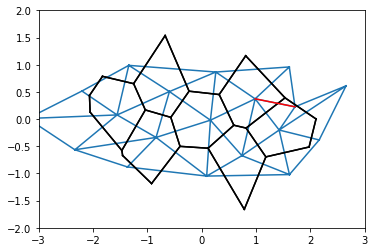

[[1.53 0.39]
 [1.53 0.39]]
[[1.53 0.39]
 [1.53 0.39]]
85
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


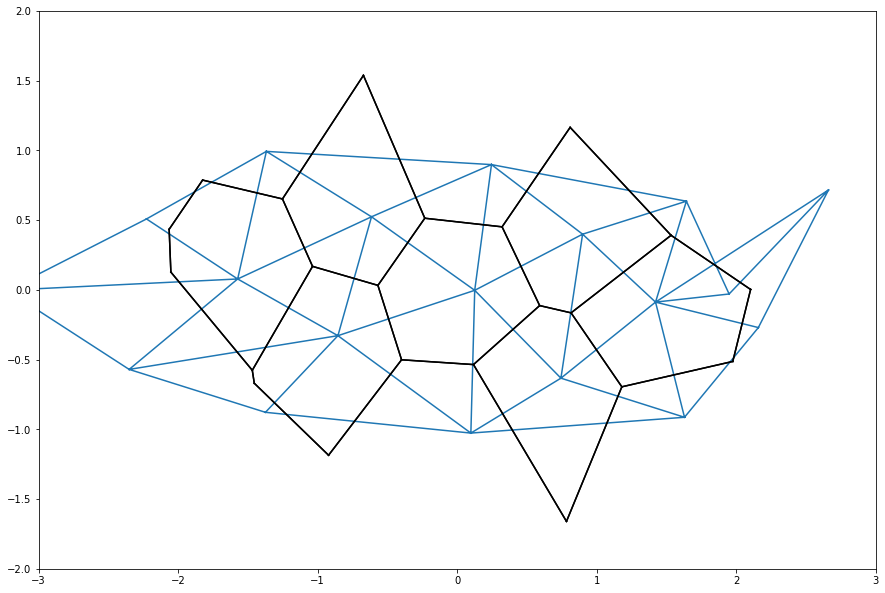

flip


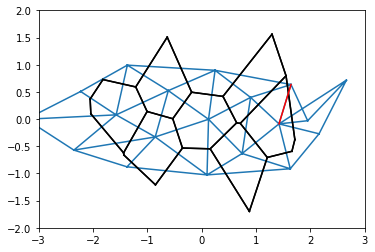

[[1.55 0.8 ]
 [1.55 0.8 ]]
[[1.55 0.8 ]
 [1.55 0.8 ]]
86
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


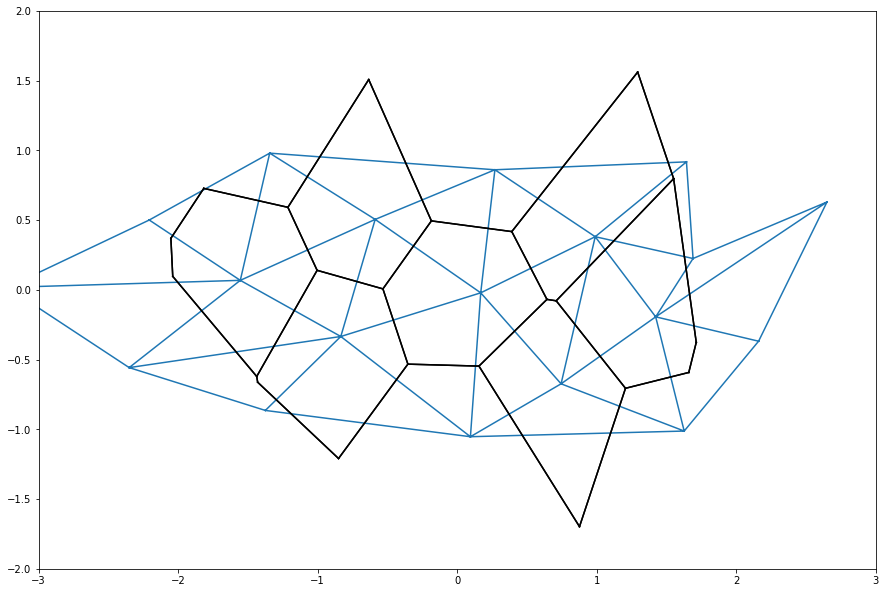

flip


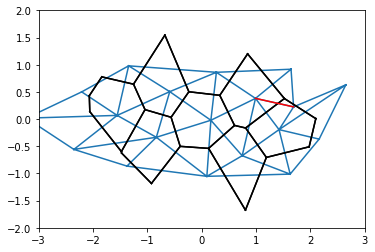

[[1.52 0.38]
 [1.52 0.38]]
[[1.52 0.38]
 [1.52 0.38]]
87
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


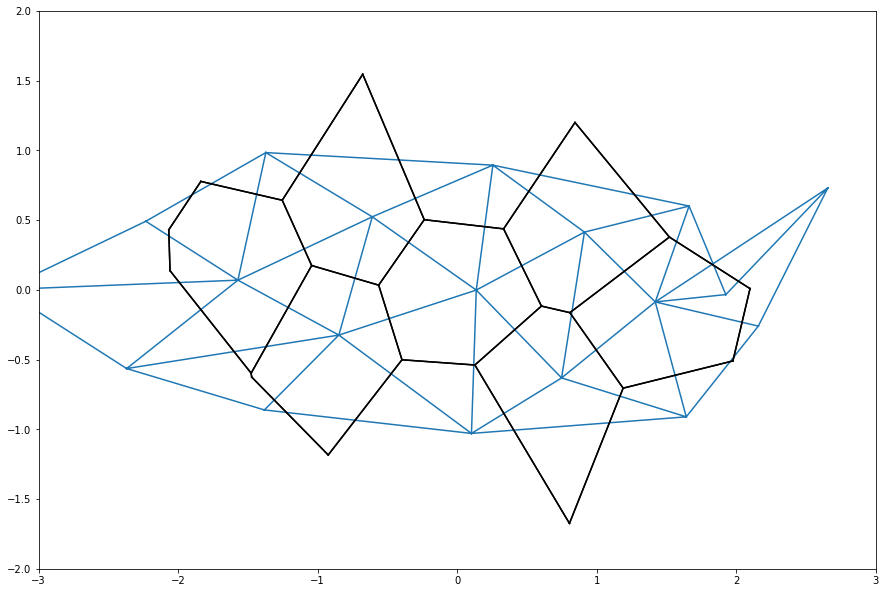

flip


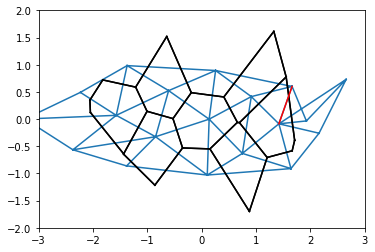

[[1.55 0.78]
 [1.55 0.78]]
[[1.55 0.78]
 [1.55 0.78]]
88
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


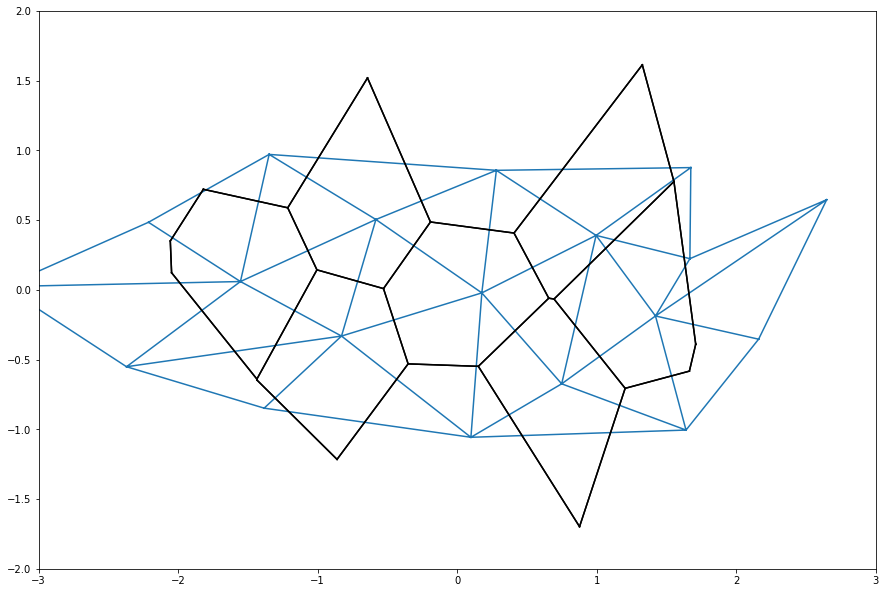

flip


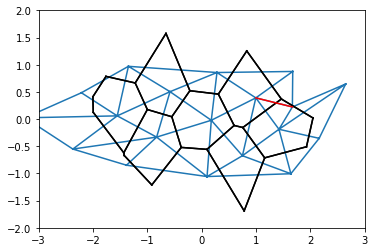

[[1.47 0.37]
 [1.47 0.37]]
[[1.47 0.37]
 [1.47 0.37]]
89
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


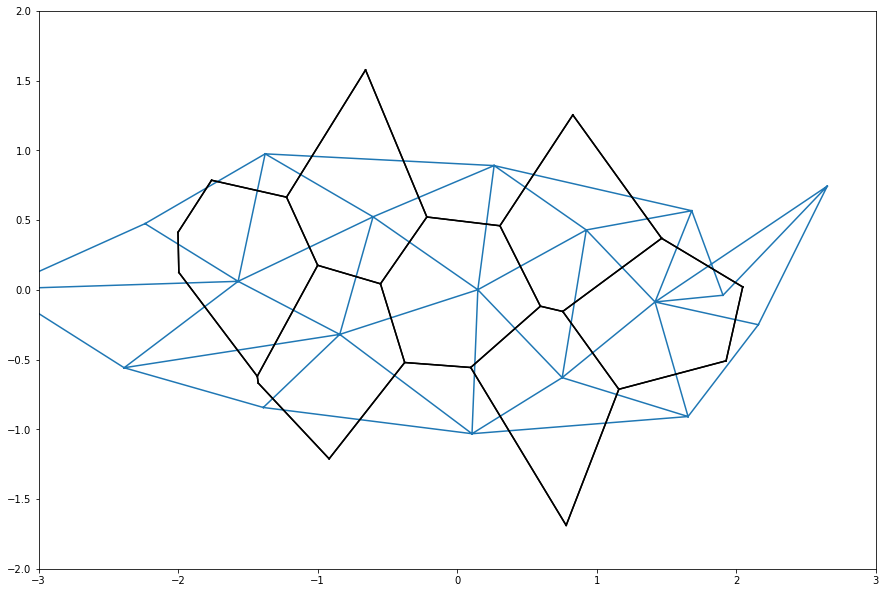

flip


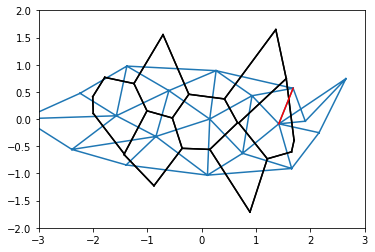

[[1.56 0.74]
 [1.56 0.74]]
[[1.56 0.74]
 [1.56 0.74]]
90
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


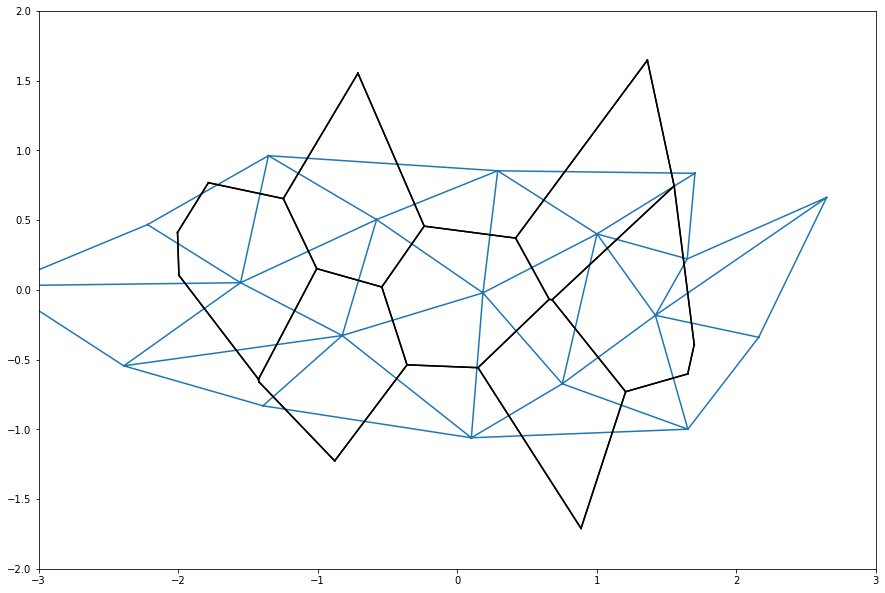

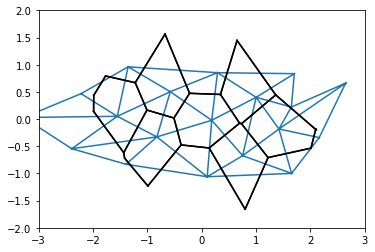

flip


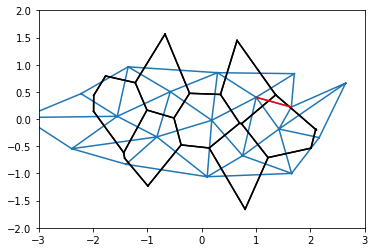

[[1.36 0.44]
 [1.36 0.44]]
[[1.36 0.44]
 [1.36 0.44]]
91
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


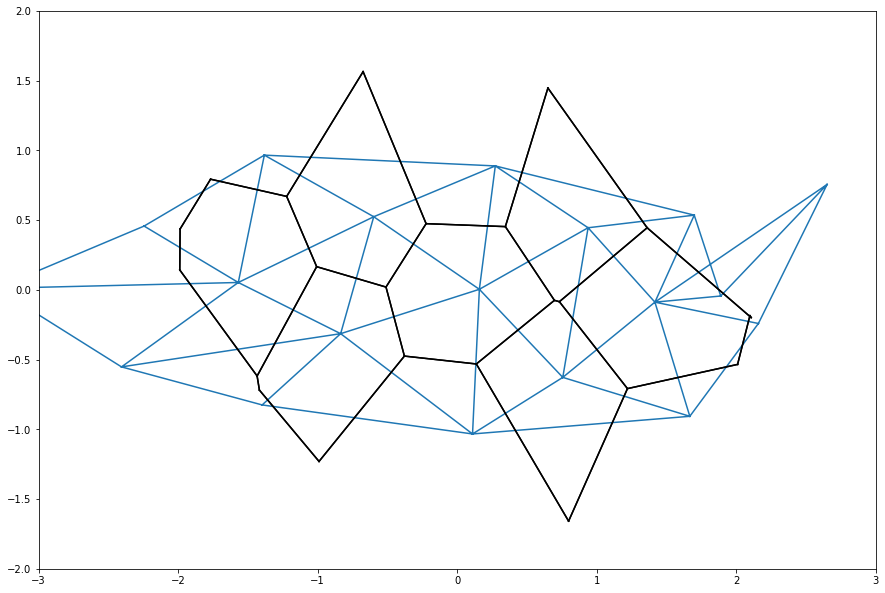

flip


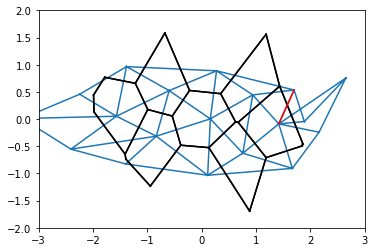

[[1.44 0.6 ]
 [1.44 0.6 ]]
[[1.44 0.6 ]
 [1.44 0.6 ]]
92
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


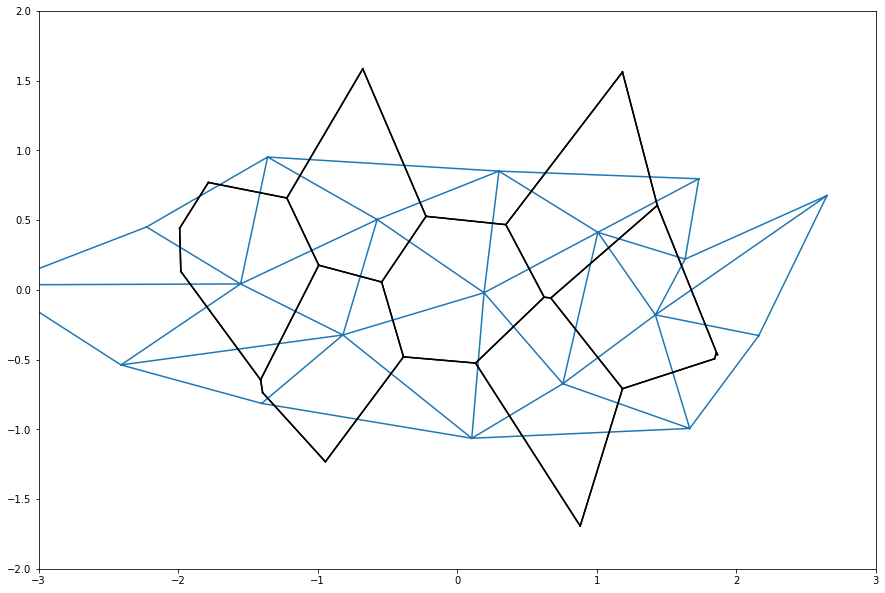

flip


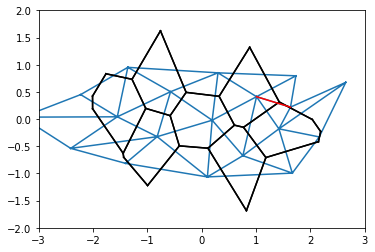

[[1.43 0.31]
 [1.43 0.31]]
[[1.43 0.31]
 [1.43 0.31]]
93
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


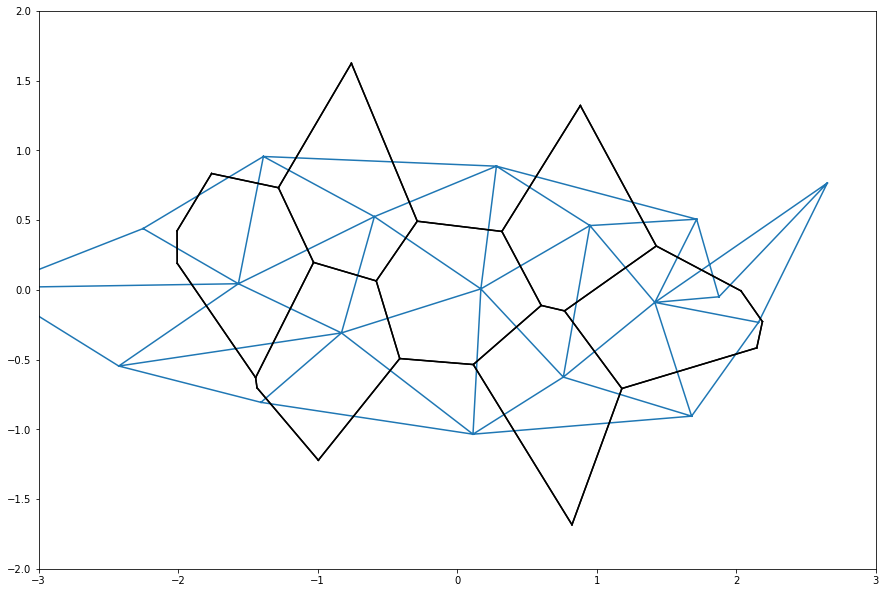

flip


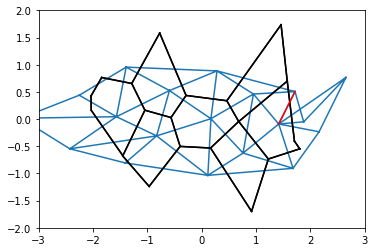

[[1.57 0.7 ]
 [1.57 0.7 ]]
[[1.57 0.7 ]
 [1.57 0.7 ]]
94
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


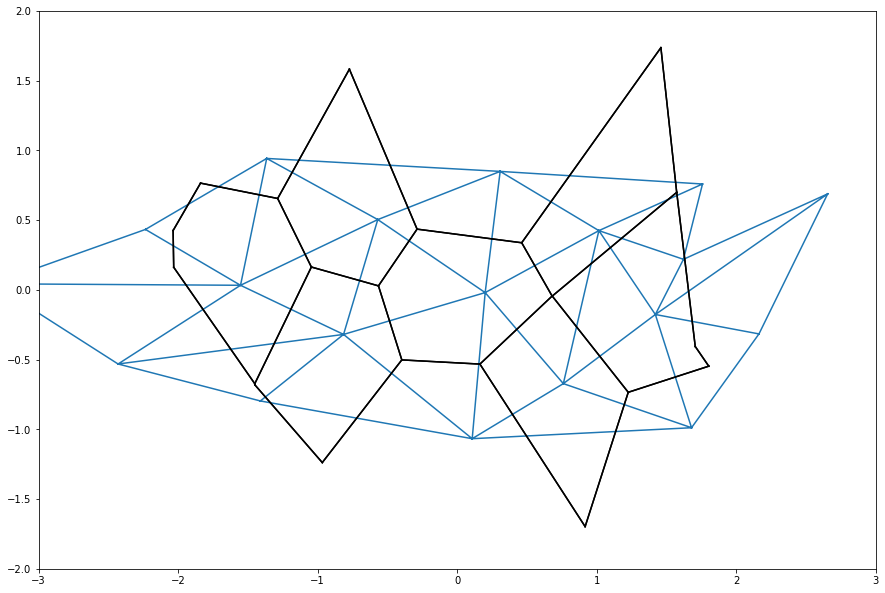

flip


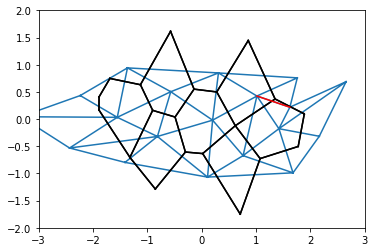

[[1.35 0.37]
 [1.35 0.37]]
[[1.35 0.37]
 [1.35 0.37]]
95
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


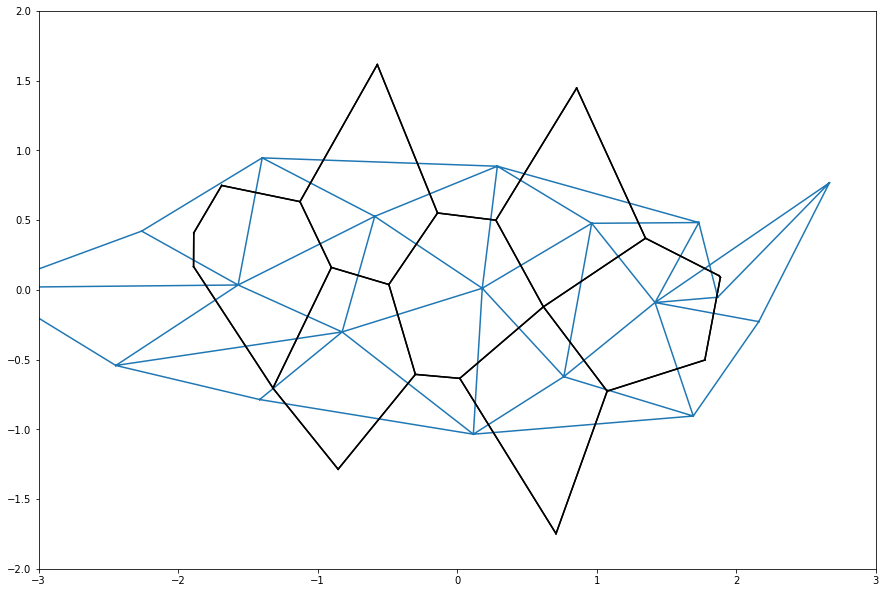

flip


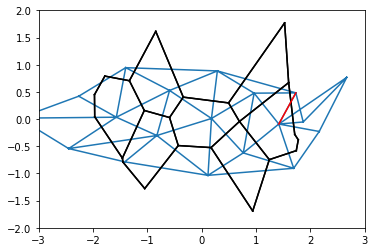

[[1.6  0.67]
 [1.6  0.67]]
[[1.6  0.67]
 [1.6  0.67]]
96
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


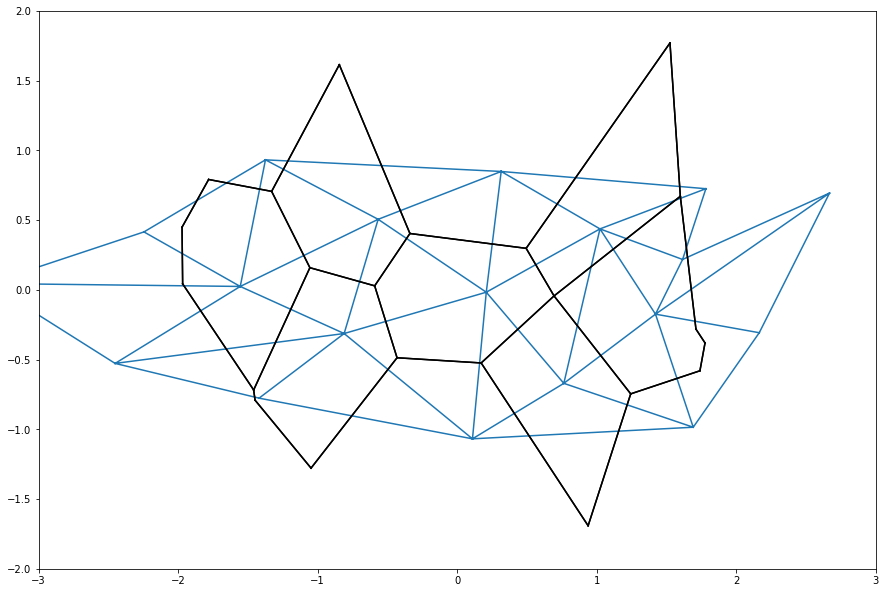

flip


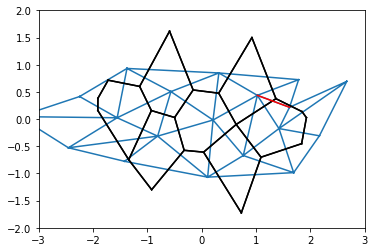

[[1.37 0.38]
 [1.37 0.38]]
[[1.37 0.38]
 [1.37 0.38]]
97
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


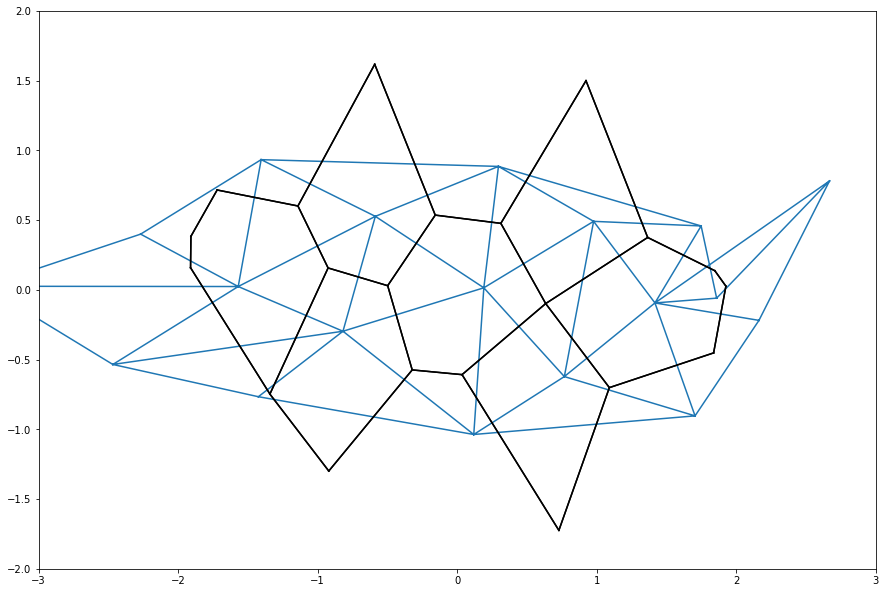

flip


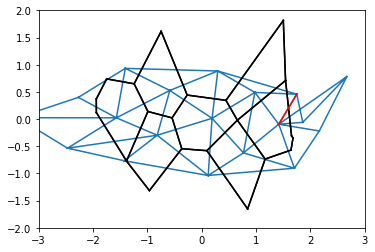

[[1.54 0.71]
 [1.54 0.71]]
[[1.54 0.71]
 [1.54 0.71]]
98
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


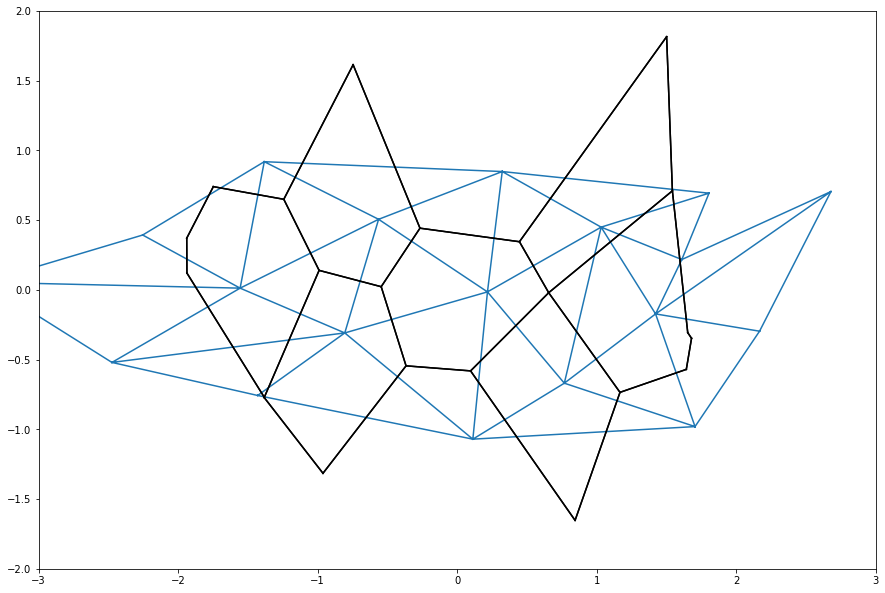

flip


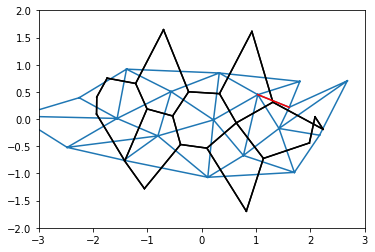

[[1.31 0.31]
 [1.31 0.31]]
[[1.31 0.31]
 [1.31 0.31]]
99
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


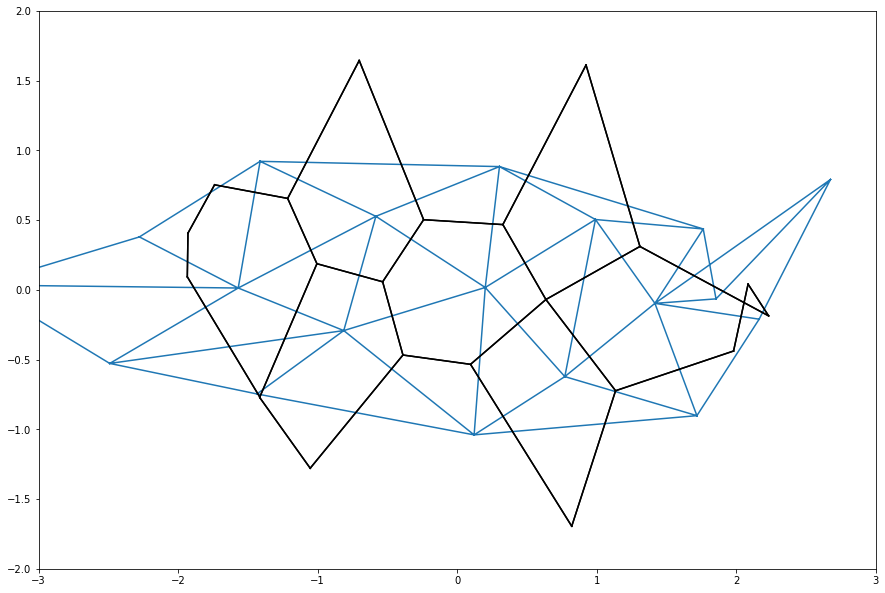

flip


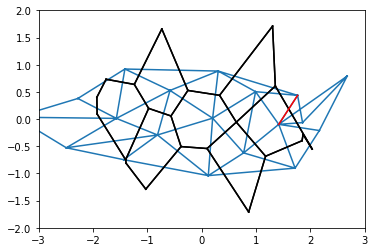

[[1.36 0.61]
 [1.36 0.61]]
[[1.36 0.61]
 [1.36 0.61]]


In [ ]:
#| notest
#%%time

## simulate

m = 2
k = .25
dt = .005

mod_shear = .01
mod_bulk = 1
angle_penalty = 10

A0, P0 = (sqrt(3)/2, 2*sqrt(3))

epsilon_l = .1

meshes = [mesh]
times = [0]

temp_plot(mesh)
plt.show()
plt.close()

T1_count = [0]

for i in range(100):
    print(i)
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, k=k, m=m)
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    # flatten triangulation
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print("Triangulation optimization failed")
        print(sol["message"])
        meshes.append(deepcopy(mesh))
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    # primal optimization
    get_E, grd = mesh.get_primal_energy_fct(A0=A0, P0=P0,
        mod_bulk=mod_bulk, mod_shear=mod_shear, angle_penalty=angle_penalty)
    x0 = mesh.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=grd, method="BFGS", tol=1e-3)
    if sol["status"] !=0:
        print("Cell shape optimization failed")
        print(sol["message"])
        fig = plt.figure(figsize=(15,15))
        temp_plot(mesh)
        plt.show()
        plt.close()

        #if sol["message"] == "Desired error not necessarily achieved due to precision loss.":
        #    # maybe continue see what happened!
        #    continue
        #else:
        #    meshes.append(deepcopy(mesh))
        #    break
    new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
    for key, val in mesh.faces.items():
        val.dual_coords = new_coord_dict[key]
    if i%10 == 0 and i>0:
        temp_plot(mesh)
        plt.show()
        plt.close()
    # compute primal lengths and carry out an edge flip if required
    primal_lengths = mesh.get_primal_edge_lens()
    argmin = min(primal_lengths, key=primal_lengths.get)
    if primal_lengths[argmin] < epsilon_l:        
        # resetting the active and passive tensions
        mesh.reset_rest_passive_flip(mesh.hes[argmin])
        try:
            print("flip")
            # highlight flipped edge
            temp_plot(mesh)
            line = np.stack([mesh.hes[argmin].vertices[0].coords, mesh.hes[argmin].vertices[1].coords])
            plt.plot(*line.T, c="r")
            plt.show()
            plt.close()
            mesh.flip_edge(argmin)
            T1_count.append(T1_count[-1]+1)
        except ValueError:
            continue
        # change the primal verted positions!
        f0, f1 = (mesh.hes[argmin].face, mesh.hes[argmin].twin.face)
        coords = np.stack([f0.dual_coords, f1.dual_coords])
        print(np.round(coords, decimals=2))
        coords = rotate_about_center(coords, angle=pi/2) # hopefully this always works, to be double checked!
        print(np.round(coords, decimals=2))
        f0.dual_coords = coords[0]  
        f1.dual_coords = coords[1]
            
    else:
        T1_count.append(T1_count[-1])
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

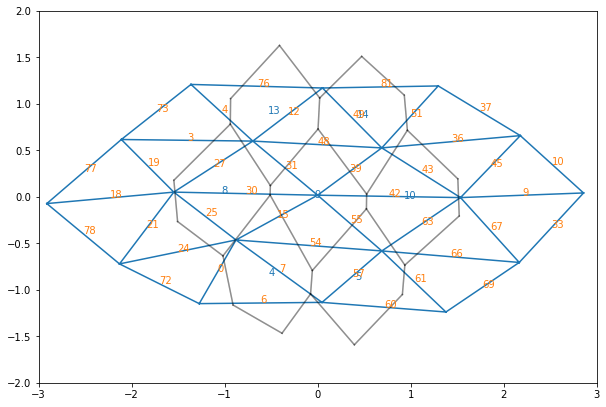

In [ ]:
t = 60

plt.figure(figsize=(10,10))

meshes[t].cellplot(alpha=.25)
meshes[t].triplot()
meshes[t].labelplot(halfedge_labels=True, vertex_labels=False, face_labels=False, cell_labels=True)


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


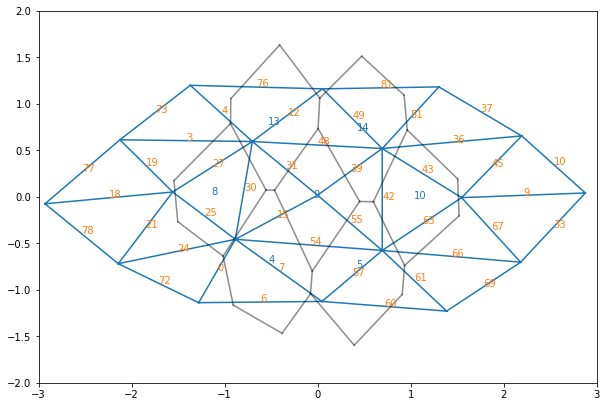

In [ ]:
mesh_temp  = deepcopy(meshes[t])

to_flip = 42
he = mesh_temp.hes[to_flip]
he = he if he.duplicate else he.twin

f0, f1 = (he.twin.face, he.face)

coords = np.stack([f0.dual_coords, f1.dual_coords])
coords = rotate_about_center(coords, angle=pi/2)
f0.dual_coords, f1.dual_coords = (coords[0], coords[1])



mesh_temp.flip_edge(he._heid)

plt.figure(figsize=(10,10))

mesh_temp.cellplot(alpha=.25)
mesh_temp.triplot()
mesh_temp.labelplot(halfedge_labels=True, vertex_labels=False, face_labels=False, cell_labels=True)


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


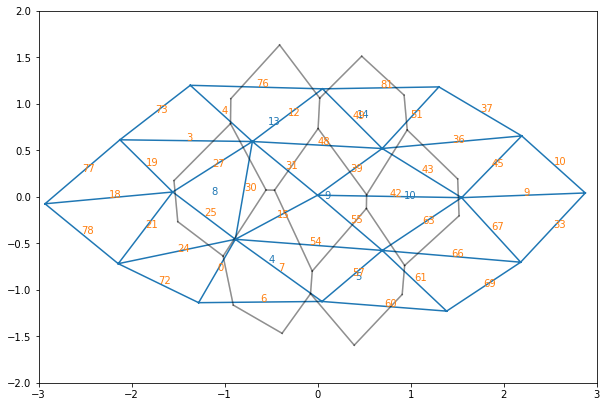

In [ ]:
t = 61

plt.figure(figsize=(10,10))

meshes[t].cellplot(alpha=.25)
meshes[t].triplot()
meshes[t].labelplot(halfedge_labels=True, vertex_labels=False, face_labels=False, cell_labels=True)


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


In [ ]:
# to do: function for energy from the shape tensor
# plotting function to color cells, or triangles by dict

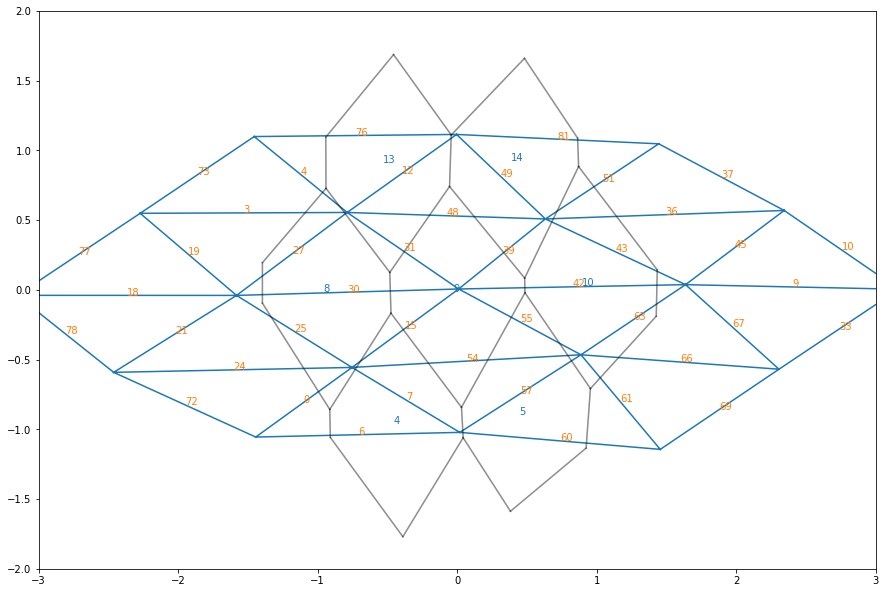

In [ ]:
t = 72

plt.figure(figsize=(15,15))

meshes[t].cellplot(alpha=.25)
meshes[t].triplot()
meshes[t].labelplot(halfedge_labels=True, vertex_labels=False, face_labels=False, cell_labels=True)


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


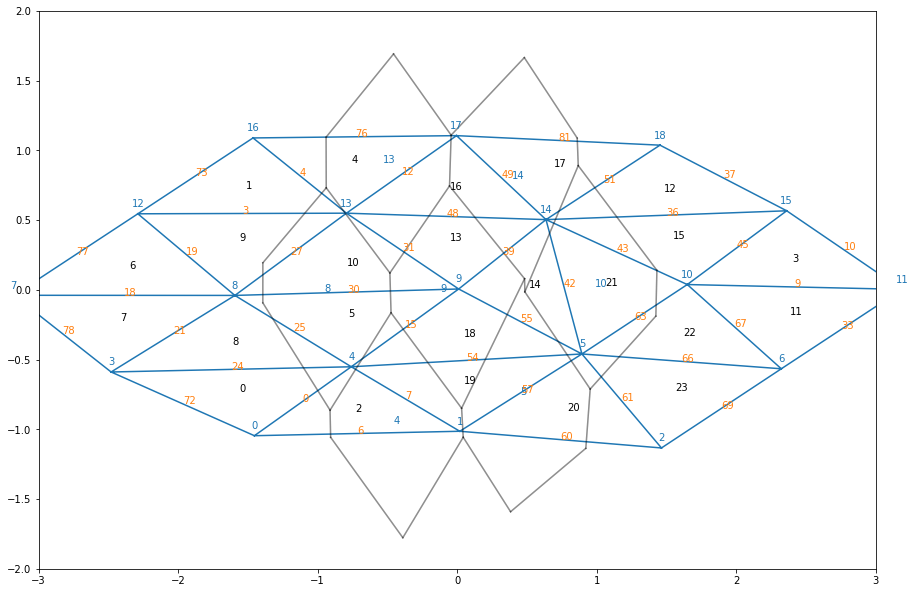

In [ ]:
t = 73

plt.figure(figsize=(15,15))

meshes[t].cellplot(alpha=.25)
meshes[t].triplot()
meshes[t].labelplot(halfedge_labels=True, vertex_labels=True, face_labels=True, cell_labels=True)


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


In [ ]:
# problem occurs at he between cell 14 and cell 5, half-edge 42. faces (of primal verts) are 14, 21

meshes[t].hes[42].vertices[0].coords - meshes[t].hes[42].vertices[1].coords

array([ 0.2575166 , -0.96312424])

In [ ]:
meshes[t].faces[14], meshes[t].faces[21]

(Face(fid=14, dual_coords=[0.5, 0.1], hes=[65, 42, 44]),
 Face(fid=21, dual_coords=[0.5, -0.0], hes=[43, 64, 63]))

In [ ]:
[he for he in meshes[t].vertices[14].incident]

[HalfEdge(heid=42, nxt=44, prev=65, twin=64, face=14, vertices=(5, 14), rest=1.0, passive=0.7, center=[0.8 0. ],
 HalfEdge(heid=39, nxt=40, prev=41, twin=44, face=13, vertices=(9, 14), rest=0.8, passive=0.0, center=[0.3 0.3],
 HalfEdge(heid=48, nxt=49, prev=50, twin=40, face=16, vertices=(13, 14), rest=1.4, passive=0.0, center=[-0.1  0.5],
 HalfEdge(heid=53, nxt=51, prev=52, twin=49, face=17, vertices=(17, 14), rest=0.9, passive=0.0, center=[0.3 0.8],
 HalfEdge(heid=38, nxt=36, prev=37, twin=51, face=12, vertices=(18, 14), rest=1.0, passive=0.0, center=[1.  0.8],
 HalfEdge(heid=46, nxt=47, prev=45, twin=36, face=15, vertices=(15, 14), rest=1.7, passive=0.0, center=[1.5 0.5],
 HalfEdge(heid=43, nxt=64, prev=63, twin=47, face=21, vertices=(10, 14), rest=1.1, passive=0.0, center=[1.1 0.3]]

In [ ]:
meshes[t].get_shape_tensors()[10]

array([[ 0.31185, -0.01286],
       [-0.01286,  0.35461]])

In [ ]:
rest = meshes[t].vertices[10].rest_shape
rest

array([[3.33333e-01, 3.70074e-17],
       [3.70074e-17, 3.33333e-01]])

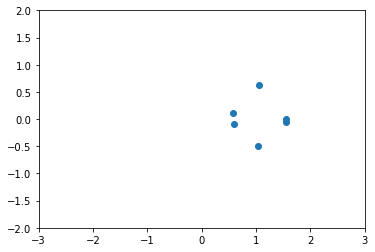

In [ ]:
pts = np.stack([fc.dual_coords for fc in meshes[t].vertices[10].get_face_neighbors()])
plt.scatter(*pts.T)

plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
get_shape_tensor(pts)
 # ??? error 

array([[ 0.45081, -0.00842],
       [-0.00842,  0.55941]])

In [ ]:
{key: np.round(100*val, decimals=2)
 for key, val in meshes[t].get_shape_energies().items()}

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.01,
 6: 0.0,
 7: 0.0,
 8: 0.01,
 9: 0.07,
 10: 1.49,
 11: 0.0,
 12: 0.0,
 13: 0.01,
 14: 0.01,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0}

In [ ]:
def temp_plot(msh):
    msh.cellplot(alpha=.25)
    msh.triplot()
    #plt.title("initial")
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.gca().set_aspect("equal", adjustable="box");


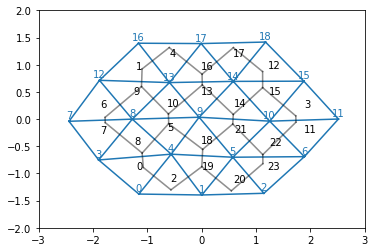

In [ ]:
#| export

# for debugging purposes, a fct to plot a trimesh with labels attached

meshes[34].cellplot(alpha=.25)
meshes[34].triplot()
meshes[34].labelplot()


plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


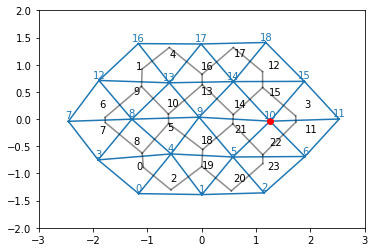

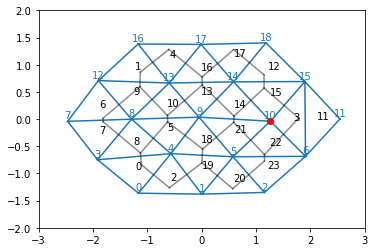

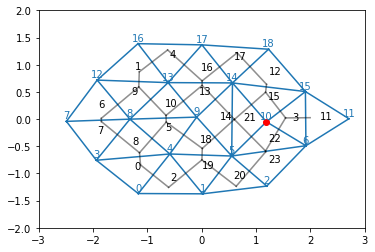

In [ ]:
temp_plot(meshes[35])
plt.scatter(*meshes[35].vertices[10].coords, color="r")
meshes[35].labelplot()
plt.show()

temp_plot(meshes[36])
plt.scatter(*meshes[36].vertices[10].coords, color="r")
meshes[36].labelplot()
plt.show()

temp_plot(meshes[37])
plt.scatter(*meshes[37].vertices[10].coords, color="r")
meshes[37].labelplot()
plt.show()

In [ ]:
# multiple problems, mainly at the edges, and then progagating inwards
# need to fix: simulation currently has open cells at the boundary
# where primal vertices only belong to once cell. might need to add "mirror"
# second, the shape tensor does not stronlgy repell away from self intersecting polygons

corners can develop:

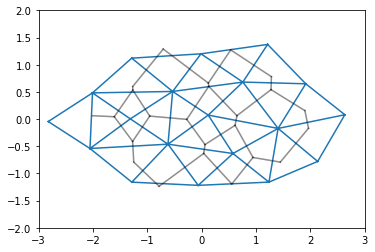

self intersections can develop:

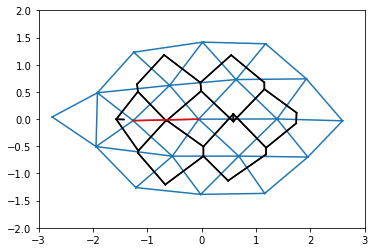

Very messed up example:

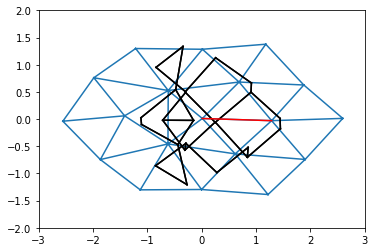

In [ ]:
# metric true seems better behaved


<function __main__.get_shape_tensor(poly: nptyping.base_meta_classes.NDArray, metric=False)>

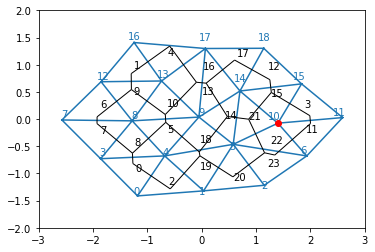

In [ ]:
#meshes[33].cellplot(alpha=.25)
meshes[33].voronoiplot(alpha=.25)
meshes[33].triplot()

meshes[32].labelplot()
plt.scatter(*meshes[33].vertices[10].coords, color="r")

plt.xlim([-3, 3])
plt.ylim([-2, 2])
plt.gca().set_aspect("equal", adjustable="box");


In [ ]:
[(fc._fid, np.round(fc.dual_coords, decimals=1))
 for  fc in meshes[31].vertices[10].get_face_neighbors()] # ok

[(11, array([ 1.7, -0.2])),
 (22, array([ 1.1, -0.7])),
 (21, array([ 0.6, -0. ])),
 (14, array([0.6, 0. ])),
 (15, array([1.1, 0.5])),
 (3, array([1.7, 0.1]))]

In [ ]:
[(fc._fid, np.round(fc.dual_coords, decimals=1))
 for  fc in meshes[32].vertices[10].get_face_neighbors()]

[(15, array([1.1, 0.5])),
 (3, array([1.7, 0.1])),
 (11, array([ 1.7, -0.2])),
 (22, array([ 1.1, -0.7])),
 (21, array([ 0.6, -0. ]))]

In [ ]:
[(fc._fid, np.round(fc.dual_coords, decimals=1))
 for  fc in meshes[33].vertices[10].get_face_neighbors()]

[(15, array([1.2, 0.3])),
 (3, array([ 1.9, -0.2])),
 (11, array([ 1.9, -0. ])),
 (22, array([ 1.2, -0.6])),
 (21, array([ 1., -0.]))]

In [ ]:
meshes[31].get_shape_tensors()[10]

array([[0.56477322, 0.00082882],
       [0.00082882, 0.58844851]])

In [ ]:
meshes[32].get_shape_tensors()[10]

array([[0.66918332, 0.00830407],
       [0.00830407, 0.71166739]])

In [ ]:
meshes[33].get_shape_tensors()[10]

array([[0.55465346, 0.00560227],
       [0.00560227, 0.59966767]])

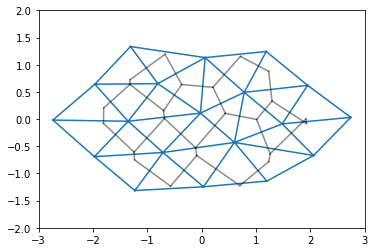

In [ ]:
temp_plot(meshes[-1])

<matplotlib.collections.PathCollection>

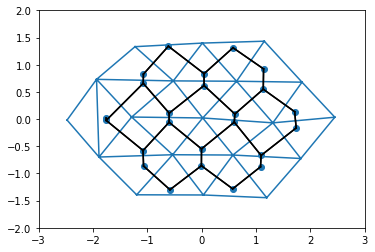

In [ ]:
temp_plot(meshes[-1])
dual = np.stack([fc.dual_coords for fc in meshes[-1].faces.values()])
plt.scatter(*dual.T)

In [ ]:
get_E, grd = meshes[-1].get_primal_energy_fct()
x0 = meshes[-1].dual_vertices_to_initial_cond()
sol = optimize.minimize(get_E, x0, jac=grd, method="BFGS", tol=1e-3)
sol

      fun: 3.2128879658468564e-06
 hess_inv: array([[ 0.65429254,  0.2782018 ,  0.15583314, ...,  0.02342359,
         0.27517297,  0.13834214],
       [ 0.2782018 ,  0.78005968,  0.10114949, ...,  0.13260386,
         0.25142923, -0.02567065],
       [ 0.15583314,  0.10114949,  0.49247652, ...,  0.03316017,
         0.08389883, -0.03517926],
       ...,
       [ 0.02342359,  0.13260386,  0.03316017, ...,  1.08275681,
         0.51617247, -0.50088715],
       [ 0.27517297,  0.25142923,  0.08389883, ...,  0.51617247,
         0.78008127, -0.16681009],
       [ 0.13834214, -0.02567065, -0.03517926, ..., -0.50088715,
        -0.16681009,  1.07476805]])
      jac: array([ 1.20180492e-05, -8.76171463e-05, -4.48906095e-05,  1.92340567e-05,
        4.64871739e-05,  7.08670867e-04, -2.99063267e-06, -4.01520964e-05,
        2.72790008e-05,  8.15967571e-05, -7.08129924e-04,  1.48532556e-05,
       -3.78713961e-05,  8.19362682e-05, -4.82461391e-04,  3.69571365e-05,
        2.04931432e-05, -7.2329

In [ ]:
# maybe package this iteration a little bit ...

## Old code

In [ ]:
#| notest

# define hessianp using partial differentiation. Direct evaluation too expensive

def hessp(x, p):
    def jac_dot(x): return anp.dot(jac(x), p)
    return agrad(jac_dot)(x)
%time _ = hessp(x0, x0)

CPU times: user 50.1 ms, sys: 289 µs, total: 50.4 ms
Wall time: 47 ms
